# Figure 3 - Cheese3D with EEG analysis during general anesthesia

This notebook contains the code to reproduce Figure 3a-f.

In order to run this notebook, you need the following Anipose projects:
1. `20231013-long-anes-rig2`
2. `202408-eeg-emg-all`

## Prep the notebook

### Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

# Update path as if notebook was run from top-level repo directory
import os
import sys

pwd = %pwd
if pwd.endswith('notebooks'):
    sys.path.insert(0, os.path.abspath('..'))
    new_pwd = os.path.abspath(f"{pwd}/..")
    %cd {new_pwd}

/home/houlab/repos/mouse-fe-analysis


/home/houlab/micromamba/envs/mouse-fe-analysis/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import itertools
import pickle
import json
from glob import glob
from numpy import newaxis as na
from datetime import datetime
from pathlib import Path
from functools import reduce
import scipy.stats as stats
from scipy.stats import pearsonr, ttest_rel, wilcoxon
from scipy.signal import convolve, spectrogram, sosfilt, iirdesign
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from matplotlib.colors import ListedColormap
from datetime import datetime

from fepipeline.features.landmarks import read_3d_data
from fepipeline.anatomy import compute_measurements_df
from labutils.utils import maybe
from labutils.plotting import (sns_setup,
                               landmark_cmap,
                               measurements_cmap,
                               save_figure)

### Global variables

In [3]:
sns_setup(palette="colorblind", font="sans-serif")
OUTPUT_DIR = "./figures/Figure3-EEG"
os.makedirs(OUTPUT_DIR, exist_ok=True)
TODAY = datetime.today().date()

# size in frames of moving average filter window for seeing slow drift in behavior
FILTER_WINDOW = 1000

# Start of anesthesia video after injection (in seconds)
ANES_START_OFFSETS = {
    ("20240822", "B47"): 4 * 60 + 22,
    ("20240822", "B48"): 3 * 60 + 50,
    ("20240912", "B47"): 4 * 60 + 17,
    ("20240912", "B48"): 4 * 60 + 17,
    ("20240913", "B47"): 6 * 60 + 30, #anes video only
    ("20240913", "B48"): 3 * 60 + 33, #anes video only
    ("20240917", "B47"): 4 * 60 + 40,
    ("20240917", "B48"): 4 * 60 + 3,
    ("20240918", "B47"): 3 * 60 + 20,
    ("20240918", "B48"): 3 * 60 + 45,
    ("20240924", "B53"): 3 * 60 + 5,  #anes video only
    ("20240925", "B53"): 5 * 60 + 56,
    ("20240926", "B53"): 4 * 60 + 3,  #anes video only
    ("20240927", "B53"): 3 * 60 + 0,  #anes video only
}

REGION_ORDER = ["eye(left)", "eye(right)",
                "ear(left)", "ear(right)",
                "nose", "cheek", "mouth"]

DATA_CACHE = "measurements-data-cache" 
os.makedirs(DATA_CACHE, exist_ok=True)
MEAS_DATA_CACHE = os.sep.join([DATA_CACHE, "eeg-slow-drift.pkl"])
ALL_DATA_CACHE = os.sep.join([DATA_CACHE, "eeg-slow-drift-eeg-meas.pkl"])
MODEL_RESULTS_CACHE = os.sep.join([DATA_CACHE, "long-anes-slow-drift-results.pkl"])

# Data cache for time-prediction models using Lasso - Alpha optimization
# Using facial features
LASSO_MODEL_FF = os.sep.join([DATA_CACHE, f"{TODAY}-lasso-model-ff.pkl"])
# Using eeg features
LASSO_MODEL_EEG = os.sep.join([DATA_CACHE, f"{TODAY}-lasso-model-eeg.pkl"])

ANIPOSE_BASE = 'anipose-projects/202408-eeg-emg-all'
COORDINATE_PATHS = {}
key_cols = ('date', 'mouse', 'condition')
for p in Path(ANIPOSE_BASE).glob('*/pose-3d/*.csv'):
    date, mouse, *_ = p.name.split('_')
    if date in ["20240816", "20240822"]:
        continue
    condition = 'awake' if 'awake' in p.name else 'anes'
    COORDINATE_PATHS[(date, mouse, condition)] = p
data_keys = list(COORDINATE_PATHS.keys())
anes_data_keys = [d for d in data_keys if d[2] != 'awake']

In [4]:
def compute_sample_rate(timestamps):
    start_time = datetime.strptime(timestamps[0], "%H:%M:%S:%f")
    times = np.array([(datetime.strptime(t, "%H:%M:%S:%f") - start_time).total_seconds()
                      for t in timestamps])

    return 1 / np.mean(np.diff(times))

def read_signal(filename, sample_rate):
    df = pd.read_csv(filename, sep="\t", names=["timestamp", "signal"])
    _sample_rate = compute_sample_rate(df["timestamp"].values)
    if abs(sample_rate - _sample_rate) / sample_rate > 0.1:
        return df["signal"].values, _sample_rate
    else:
        return df["signal"].values, sample_rate

# Remove NaNs at the beginning of the EEG recording and define new recording start
EEG_STARTS = os.sep.join([DATA_CACHE, 'eeg-anes-start.pkl'])
if os.path.exists(EEG_STARTS):
    with open(EEG_STARTS, "rb") as fio:
        ANES_START_OFFSETS_EEG = pickle.load(fio)
else:
    ANES_START_OFFSETS_EEG = {}
    for date, mouse, cond in data_keys:
        folder = glob(f"ephys-data/{date}_*{mouse}*_EEG-EMG-rec_rig2")
        with open(os.sep.join([folder[0], f"{date}_{mouse}_{cond}.align.json"])) as f:
            alignment = json.load(f)
            lag_time = alignment["lag_time"]
            sample_rate = alignment["sample_rate"]
        for name, units in (("eeg", "V"), ("emg", "V"), ("temp", "C")):
            filename = os.sep.join([folder[0], f"{date}_{mouse}_{cond}_{name}.txt"])
            signal, _sample_rate = read_signal(filename, sample_rate)
            # if name in ['emg', 'eeg']:
            signal[np.isnan(signal)] = 0 #added by inm - assign the nan to 0s then save signal from first non-zero
            signal_start = signal.nonzero()[0][0]
            signal = signal[signal_start:]
            if name == 'eeg' and signal_start and cond == 'anes':
                ANES_START_OFFSETS_EEG[date, mouse] = ANES_START_OFFSETS[date, mouse] + int(signal_start/_sample_rate)

### Define colormaps

In [5]:
_, LANDMARK_CMAP = landmark_cmap()
_, MEASUREMENT_CMAP = measurements_cmap()

CONTROL_CMAP = sns.color_palette([sns.color_palette("colorblind")[2],
                                  sns.color_palette("colorblind")[-3],
                                  sns.color_palette("colorblind")[3]])

FREQ_CMAP = "jet"

In [6]:
EEG_CONTROL_CMAP = sns.color_palette([sns.color_palette("colorblind")[0],
                                  sns.color_palette("colorblind")[7],
                                  sns.color_palette("colorblind")[0],
                                  sns.color_palette("colorblind")[0]])
EEG_CONTROL_CMAP

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745)]

In [7]:
CONTROL_CMAP_V2 = sns.color_palette([sns.color_palette("colorblind")[3],
                                  sns.color_palette("colorblind")[-3],
                                  sns.color_palette("colorblind")[2],
                                  sns.color_palette("colorblind")[0],
                                  sns.color_palette("colorblind")[1],
                                  sns.color_palette("colorblind")[-1],
                                  sns.color_palette("colorblind")[4],
                                  sns.color_palette("colorblind")[-2]])
CONTROL_CMAP_V2

[(0.8352941176470589, 0.3686274509803922, 0.0),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.9254901960784314, 0.8823529411764706, 0.2)]

### Define functions

In [8]:
def z_score(raw_data):
    mean = np.mean(raw_data, 0, keepdims=True)
    sigma = np.std(raw_data, 0, keepdims=True) #1
    sigma[sigma == 0] = 1
    return (raw_data-mean)/sigma

def un_zscore(raw_data, z_score_data): #Undo z-scoring for plotting as a sanity check - there is no deformation
    mean = np.mean(raw_data, 0, keepdims=True) #0
    sigma = np.std(raw_data, 0, keepdims=True) #1
    sigma[sigma == 0] = 1
    return z_score_data*sigma + mean

In [9]:
def moving_avg_filter(signal, window = 3, stride = 1, truncate = True):
    kernel = np.ones(window) / window
    result = convolve(signal, kernel, mode="same")[window:-window]

    return result[::stride]

In [10]:
test = moving_avg_filter(np.arange(12), window = 1, stride = 2)
print(test)

[1. 3. 5. 7. 9.]


In [11]:
def plot_spectrum_helper(dates, mice, conditions, spectrums, lag_times, color,
                         min_power = None, max_power = None):
    single = (len(spectrums.values) == 1)
    if single:
        if min_power is None:
            min_power = np.min(spectrums.values[0][-1])
        if max_power is None:
            max_power = np.max(spectrums.values[0][-1])
    else:
        if min_power is None:
            min_power = min(*(np.min(s) for _, _, s in spectrums.values))
        if max_power is None:
            max_power = max(*(np.max(s) for _, _, s in spectrums.values))
    awake = (conditions == "awake")
    # print(awake)
    if sum(awake):
        fs, ts, power = spectrums[awake].values[0]
        awake_end = ts[-1]
    else:
        awake_end = 0
    fs, ts, power = spectrums[~awake].values[0]
    anes_start = ANES_START_OFFSETS[(dates.values[0], mice.values[0])]
    ts = ts + lag_times[~awake].values[0] + anes_start #+ awake_end
    # print(power)
    p = plt.pcolormesh(ts / 60, fs, power,
                       vmin=min_power, vmax=max_power, cmap=FREQ_CMAP)


In [12]:
def compute_power_bands(fs, power):
    sub_delta_idx = np.where(fs < 1)[0]
    sub_delta_power = np.mean(power[sub_delta_idx], axis=0)

    delta_idx = np.where((fs >= 1) & (fs <= 4))[0]
    delta_power = np.mean(power[delta_idx], axis=0)

    theta_idx = np.where((fs >= 5) & (fs <= 10))[0]
    theta_power = np.mean(power[theta_idx], axis=0)

    # slow_delta_idx = np.where(fs <= 4)[0]
    # slow_delta_power = np.mean(power[slow_delta_idx], axis=0)

    return sub_delta_power, delta_power, theta_power #, slow_delta_power

In [13]:
def generate_lagged_data(data, lags = 1, bias = True, initial_bias = True):
    assert data.ndim == 2 or data.ndim == 1
    # make the data a matrix
    if data.ndim == 1:
        data = np.expand_dims(data, axis=1)
    # make shifted copies of data
    lagged = np.lib.stride_tricks.sliding_window_view(data, lags, axis=0)
    lagged = np.reshape(lagged, (data.shape[0] - lags + 1, -1))
    # pad in the initial lags
    if lags > 1:
        pad = np.stack([np.pad(data[:(lags - i)], ((i, 0), (0, 0))).T
                        for i in range(lags - 1, 0, -1)])
        pad = np.reshape(pad, (lags - 1, -1))
        lagged = np.concatenate([pad, lagged], axis=0)
    # always have initial time point
    if initial_bias:
        lagged = np.concatenate([np.tile(data[0], (lagged.shape[0], 1)), lagged], axis=1)
    # add bias term
    if bias:
        lagged = np.pad(lagged, ((0, 0), (1, 0)), constant_values=1)

    return lagged

# Uncomment prints for examples:
x = np.arange(10)
y = np.stack([x, x + 10], axis=1)
# print(generate_lagged_data(x, 5))
# print(generate_lagged_data(y, 3))

In [14]:
def generate_poly_feats(data, degree = 2, interaction = True):
    assert data.ndim == 2 or data.ndim == 1
    # make the data a matrix
    if data.ndim == 1:
        data = np.expand_dims(data, axis=1)
    if interaction == True:
        return PolynomialFeatures(degree).fit_transform(data) 
    else:
        polyfeats = np.vstack((np.ones(len(data)), data.T)).T
        for n in (np.arange(1,degree)+1):
            polyfeats = np.hstack((polyfeats, data**n))
        
        return polyfeats
        
# Uncomment prints for examples:
z = np.stack([x, x + 10, x + 1], axis=1)
print(generate_lagged_data(x, bias=False))
print(generate_poly_feats(generate_lagged_data(z, bias=False)))
print(generate_poly_feats(generate_lagged_data(x, bias=False), 3))

[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [0 6]
 [0 7]
 [0 8]
 [0 9]]
[[  1.   0.  10.   1.   0.  10.   1.   0.   0.   0.   0.   0.   0. 100.
   10.   0. 100.  10.   1.   0.  10.   1.   0.   0.   0. 100.  10.   1.]
 [  1.   0.  10.   1.   1.  11.   2.   0.   0.   0.   0.   0.   0. 100.
   10.  10. 110.  20.   1.   1.  11.   2.   1.  11.   2. 121.  22.   4.]
 [  1.   0.  10.   1.   2.  12.   3.   0.   0.   0.   0.   0.   0. 100.
   10.  20. 120.  30.   1.   2.  12.   3.   4.  24.   6. 144.  36.   9.]
 [  1.   0.  10.   1.   3.  13.   4.   0.   0.   0.   0.   0.   0. 100.
   10.  30. 130.  40.   1.   3.  13.   4.   9.  39.  12. 169.  52.  16.]
 [  1.   0.  10.   1.   4.  14.   5.   0.   0.   0.   0.   0.   0. 100.
   10.  40. 140.  50.   1.   4.  14.   5.  16.  56.  20. 196.  70.  25.]
 [  1.   0.  10.   1.   5.  15.   6.   0.   0.   0.   0.   0.   0. 100.
   10.  50. 150.  60.   1.   5.  15.   6.  25.  75.  30. 225.  90.  36.]
 [  1.   0.  10.   1.   6.  16.   7.   0.   0.   0.   0.   

In [15]:
def get_features(measures, degree = 2, lags = 1, interaction = True, initial_bias = True):
    features = generate_lagged_data(measures, lags, bias=False, initial_bias = initial_bias)
    features = generate_poly_feats(features, degree, interaction)

    return features

In [16]:
def plot_predictions(ts, xs, color, label, FILTER_WINDOW = 1000, dash_line = True, ax = None):
    ts = ts.values[0][FILTER_WINDOW:-FILTER_WINDOW]
    xs = moving_avg_filter(xs.values[0], FILTER_WINDOW)
    if ax is None:
        sns.lineplot(x=ts, y=xs, color=color, label=label)
        if dash_line:
            sns.lineplot(x=ts, y=ts, color="black", linestyle="dashed")
    else:
        sns.lineplot(x=ts, y=xs, color=color, label=label, ax = ax)
        if dash_line:
            sns.lineplot(x=ts, y=ts, color="black", linestyle="dashed", ax = ax)

In [17]:
def format_feature_ticks(feature):
    text = feature.get_text()
    if text == "whole-face":
        return "whole\nface"
    if ' ' in text:
        parts = text.split(" ")
        return'\n'.join(parts)
    else:
        parts = text.split(", ")
        return ',\n'.join(parts)

In [18]:
def test_mean_per_run(results, n_runs, feat):
    mean_test = []
    for r in np.arange(n_runs):
        mean_test.append([r, feat, np.mean(results.query("set == 'Test' & run == @r")["RMSE"].values)])
    
    return pd.DataFrame(mean_test, columns = ["run",
                                              "features",
                                              "mean_RMSE"])

### Load data

In [19]:
if os.path.exists(MEAS_DATA_CACHE):
    meas_df = pd.read_pickle(MEAS_DATA_CACHE)
else:
    coord_data = {k: read_3d_data(v.parent.parent.as_posix())
                for k, v in COORDINATE_PATHS.items()}
    meas_df = compute_measurements_df(coord_data, key_columns=key_cols)
    meas_df = meas_df.assign(sample_rate=100.0, lag_time=0.0)
    pd.to_pickle(meas_df, MEAS_DATA_CACHE)
meas_df = meas_df.drop(columns=["measurement_value", "std", "count"])
meas_df

,date,mouse,condition,measurement_group,measurement_name,measurement_units,measurement_type,timeseries,sample_rate,lag_time
0,20240918,B47,awake,eye,eye-height-left,mm,distance,"[2.8410773234079607, 2.8407764831943334, 2.840...",100.0,0.0
75,20240918,B47,anes,ear,ear-height-right,mm,distance,"[11.563673445864659, 11.565708011796415, 11.56...",100.0,0.0
74,20240918,B47,anes,ear,ear-height-left,mm,distance,"[11.228250369599936, 11.227573253728734, 11.22...",100.0,0.0
73,20240918,B47,anes,eye,eye-area-right,mm^2,area,"[4.650198776374711, 4.6506637914613105, 4.6512...",100.0,0.0
72,20240918,B47,anes,eye,eye-area-left,mm^2,area,"[7.203637818019493, 7.206828134304969, 7.20986...",100.0,0.0
...,...,...,...,...,...,...,...,...,...,...
198,20240927,B53,anes,ear,ear-angle-right,deg,angle,"[162.90517316264558, 162.9257336364721, 162.94...",100.0,0.0
197,20240927,B53,anes,ear,ear-angle-left,deg,angle,"[150.36543931544432, 150.3699561947162, 150.37...",100.0,0.0
196,20240927,B53,anes,ear,ear-width-right,mm,distance,"[8.478638444561517, 8.477477679147778, 8.47640...",100.0,0.0
102,20240926,B53,anes,eye,eye-height-left,mm,distance,"[2.356877458194972, 2.3571387633491097, 2.3573...",100.0,0.0


In [20]:
if os.path.exists(ALL_DATA_CACHE):
    data = pd.read_pickle(ALL_DATA_CACHE)
else:
    eeg_rows = []
    for date, mouse, cond in data_keys:
        folder = glob(f"ephys-data/{date}_*{mouse}*_EEG-EMG-rec_rig2")
        if len(folder) != 1:
            print(f"Found too many (or no) sources={folder} for {date=}, {mouse=}, {cond=}")
            continue
        with open(os.sep.join([folder[0], f"{date}_{mouse}_{cond}.align.json"])) as f:
            alignment = json.load(f)
            lag_time = alignment["lag_time"]
            sample_rate = alignment["sample_rate"]
        for name, units in (("eeg", "V"), ("emg", "V"), ("temp", "C")):
            filename = os.sep.join([folder[0], f"{date}_{mouse}_{cond}_{name}.txt"])
            signal, _sample_rate = read_signal(filename, sample_rate)
            # if name in ['emg', 'eeg']:
            signal[np.isnan(signal)] = 0 #added by inm - assign the nan to 0s then save signal from first non-zero
            signal_start = signal.nonzero()[0][0]
            signal = signal[signal_start:]
            if name == 'eeg' and signal_start:
                ANES_START_OFFSETS[date, mouse] = ANES_START_OFFSETS[date, mouse] + signal_start/_sample_rate
            eeg_rows.append([date, mouse, cond,
                            "ephys", name, units, "ephys",
                            signal, _sample_rate, lag_time])

    data = pd.concat([meas_df, pd.DataFrame(eeg_rows, columns=meas_df.columns)])    
    pd.to_pickle(data, ALL_DATA_CACHE)

data

,date,mouse,condition,measurement_group,measurement_name,measurement_units,measurement_type,timeseries,sample_rate,lag_time
0,20240918,B47,awake,eye,eye-height-left,mm,distance,"[2.8410773234079607, 2.8407764831943334, 2.840...",100.000000,0.000000
75,20240918,B47,anes,ear,ear-height-right,mm,distance,"[11.563673445864659, 11.565708011796415, 11.56...",100.000000,0.000000
74,20240918,B47,anes,ear,ear-height-left,mm,distance,"[11.228250369599936, 11.227573253728734, 11.22...",100.000000,0.000000
73,20240918,B47,anes,eye,eye-area-right,mm^2,area,"[4.650198776374711, 4.6506637914613105, 4.6512...",100.000000,0.000000
72,20240918,B47,anes,eye,eye-area-left,mm^2,area,"[7.203637818019493, 7.206828134304969, 7.20986...",100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
46,20240917,B47,awake,ephys,emg,V,ephys,"[2.13141441345215e-05, 1.8524169921875e-05, 1....",1002.553662,-7.078951
47,20240917,B47,awake,ephys,temp,C,ephys,"[36.3038864135742, 36.3038864135742, 36.303886...",10.000000,-7.078951
48,20240924,B53,anes,ephys,eeg,V,ephys,"[5.63468933105469e-05, 5.91373443603516e-05, 6...",1002.544218,2.714738
49,20240924,B53,anes,ephys,emg,V,ephys,"[5.63468933105469e-05, 5.91373443603516e-05, 6...",1002.544218,2.714738


In [21]:
from copy import deepcopy
def compute_spectrogram(row):
    signal = row["timeseries"]
    # if np.sum(np.isnan(signal))>0:
    #     print("signal", np.sum(np.isnan(signal)))
    # signal[np.isnan(signal)] = 0 #added by inm - assign the nan to 0s so that they do not propagate when computing spectrogram - to be improved

    eeg_filt = iirdesign(50, 55, 1, 50, fs=row["sample_rate"], output="sos")
    fs, ts, power = spectrogram(sosfilt(eeg_filt, signal),
                                fs=row["sample_rate"],
                                nperseg= 5000,#2000, #originally 2048 ; possibly change to 2050 or 2000 (divisible by 10) - number of samples in each fft segment
                                # noverlap=512,
                                scaling="spectrum",
                                mode="magnitude")
    # if np.sum(np.isnan(power)):
    #     print("power", np.sum(np.isnan(power))) #nans are not here but appear in the plot
    row = row.copy()
    row["measurement_name"] = "eeg-power"
    row["measurement_units"] = "V^2"
    row["timeseries"] = (fs, ts, power)

    return row

eeg_df = deepcopy(data.query("measurement_name == 'eeg'")) #brand new copy so that I can pass by object (instead of by reference) and do not alter the original data
data_v2 = pd.concat([data, eeg_df.apply(compute_spectrogram, axis=1)])
data_v2

,date,mouse,condition,measurement_group,measurement_name,measurement_units,measurement_type,timeseries,sample_rate,lag_time
0,20240918,B47,awake,eye,eye-height-left,mm,distance,"[2.8410773234079607, 2.8407764831943334, 2.840...",100.000000,0.000000
75,20240918,B47,anes,ear,ear-height-right,mm,distance,"[11.563673445864659, 11.565708011796415, 11.56...",100.000000,0.000000
74,20240918,B47,anes,ear,ear-height-left,mm,distance,"[11.228250369599936, 11.227573253728734, 11.22...",100.000000,0.000000
73,20240918,B47,anes,eye,eye-area-right,mm^2,area,"[4.650198776374711, 4.6506637914613105, 4.6512...",100.000000,0.000000
72,20240918,B47,anes,eye,eye-area-left,mm^2,area,"[7.203637818019493, 7.206828134304969, 7.20986...",100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
36,20240913,B47,anes,ephys,eeg-power,V^2,ephys,"([0.0, 0.20050970425090778, 0.4010194085018155...",1002.548521,2.042235
39,20240917,B48,anes,ephys,eeg-power,V^2,ephys,"([0.0, 0.20050891888104538, 0.4010178377620907...",1002.544594,-2.880958
42,20240917,B47,anes,ephys,eeg-power,V^2,ephys,"([0.0, 0.20050958676890707, 0.4010191735378141...",1002.547934,4.606755
45,20240917,B47,awake,ephys,eeg-power,V^2,ephys,"([0.0, 0.20051073247296997, 0.4010214649459399...",1002.553662,-7.078951


In [22]:
data_and_bands = deepcopy(data_v2)
eeg_window = 8 #20
band_names = ['subdelta', 'delta', 'theta']
for d, m, c in anes_data_keys:
    fs, ts, power = data_and_bands.query("mouse == @m & date == @d & condition == @c & measurement_name == 'eeg-power'")["timeseries"].values[0]
    bands = compute_power_bands(fs, power)
    for i_b, _b in enumerate(bands):
        bands_dict = {'date': d, 
                    'mouse': m,
                    'condition': c,
                    'measurement_group': 'ephys',
                    'measurement_name': band_names[i_b],
                    'measurement_units': 'V^2',
                    'measurement_type': 'ephys',
                    #Save power band values and actual time together
                    'timeseries': (z_score(moving_avg_filter(_b, window = eeg_window, stride = 1)),
                                   ts[eeg_window:-eeg_window]),
                    'sample_rate': data_and_bands.query("mouse == @m & date == @d & condition == @c & measurement_name == 'eeg-power'")["sample_rate"].values[0],
                    'lag_time': data_and_bands.query("mouse == @m & date == @d & condition == @c & measurement_name == 'eeg-power'")["sample_rate"].values[0]}
        data_and_bands = pd.concat([data_and_bands, pd.DataFrame.from_records([bands_dict])])

data_and_bands


,date,mouse,condition,measurement_group,measurement_name,measurement_units,measurement_type,timeseries,sample_rate,lag_time
0,20240918,B47,awake,eye,eye-height-left,mm,distance,"[2.8410773234079607, 2.8407764831943334, 2.840...",100.000000,0.000000
75,20240918,B47,anes,ear,ear-height-right,mm,distance,"[11.563673445864659, 11.565708011796415, 11.56...",100.000000,0.000000
74,20240918,B47,anes,ear,ear-height-left,mm,distance,"[11.228250369599936, 11.227573253728734, 11.22...",100.000000,0.000000
73,20240918,B47,anes,eye,eye-area-right,mm^2,area,"[4.650198776374711, 4.6506637914613105, 4.6512...",100.000000,0.000000
72,20240918,B47,anes,eye,eye-area-left,mm^2,area,"[7.203637818019493, 7.206828134304969, 7.20986...",100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
0,20240917,B47,anes,ephys,delta,V^2,ephys,"([0.5744420205697517, 0.5548111111866552, 0.42...",1002.547934,1002.547934
0,20240917,B47,anes,ephys,theta,V^2,ephys,"([0.8844158576992475, 0.8553373702370326, 0.57...",1002.547934,1002.547934
0,20240924,B53,anes,ephys,subdelta,V^2,ephys,"([-1.1694879879236055, -1.0640289499084257, -1...",1002.544218,1002.544218
0,20240924,B53,anes,ephys,delta,V^2,ephys,"([0.28349094730934943, 0.3871047084178039, 0.5...",1002.544218,1002.544218


In [23]:
print('Example mouse B48, date 20240917, condition anes.')
print('Number of raw EEG samples: ', data.query("mouse == 'B48' & date == '20240917' & measurement_name == 'eeg' & condition == 'anes'")["timeseries"].values[0].shape)
print('Sample rate: ', data.query("mouse == 'B48' & date == '20240917' & measurement_name == 'eeg' & condition == 'anes'")["sample_rate"].values[0])
print('Number of power EEG samples: ', data_v2.query("mouse == 'B48' & date == '20240917' & measurement_name == 'eeg-power' & condition == 'anes'")["timeseries"].values[0][1].shape)
print('The EEG signal was downsampled by: ', 
        data.query("mouse == 'B48' & date == '20240917' & measurement_name == 'eeg' & condition == 'anes'")["timeseries"].values[0].shape[0]/
        data_v2.query("mouse == 'B48' & date == '20240917' & measurement_name == 'eeg-power' & condition == 'anes'")["timeseries"].values[0][1].shape[0])
new_sr = data.query("mouse == 'B48' & date == '20240917' & measurement_name == 'eeg' & condition == 'anes'")["sample_rate"].values[0]/(data.query("mouse == 'B48' & date == '20240917' & measurement_name == 'eeg' & condition == 'anes'")["timeseries"].values[0].shape[0]/
        data_v2.query("mouse == 'B48' & date == '20240917' & measurement_name == 'eeg-power' & condition == 'anes'")["timeseries"].values[0][1].shape[0])
print('Therefore the new sampling rate is: ', new_sr)
print('And first three timepoints of EEG power are found at: ', data_v2.query("mouse == 'B48' & date == '20240917' & measurement_name == 'eeg-power' & condition == 'anes'")["timeseries"].values[0][1][0:3], 'seconds')

print('\nDownsampling by the spectrum function is more or less constant across mice and sessions:')
print(data.query("mouse == 'B48' & date == '20240917' & measurement_name == 'eeg' & condition == 'anes'")["timeseries"].values[0].shape[0]/
      data_v2.query("mouse == 'B48' & date == '20240917' & measurement_name == 'eeg-power' & condition == 'anes'")["timeseries"].values[0][1].shape[0])
print(data.query("mouse == 'B47' & date == '20240918' & measurement_name == 'eeg' & condition == 'anes'")["timeseries"].values[0].shape[0]/
      data_v2.query("mouse == 'B47' & date == '20240918' & measurement_name == 'eeg-power' & condition == 'anes'")["timeseries"].values[0][1].shape[0])

Example mouse B48, date 20240917, condition anes.
Number of raw EEG samples:  (3926654,)
Sample rate:  1002.5445944052269
Number of power EEG samples:  (897,)
The EEG signal was downsampled by:  4377.540691192865
Therefore the new sampling rate is:  0.22902005146913595
And first three timepoints of EEG power are found at:  [ 2.49365466  6.85755032 11.22144597] seconds

Downsampling by the spectrum function is more or less constant across mice and sessions:
4377.540691192865
4379.533333333334


In [24]:
cam_sr = 100
eeg_power_sr = {}
ds_factor = {}
for date, mouse, _ in anes_data_keys:
    eeg_power_sr[mouse, date] = data_v2.query("mouse == @mouse & date == @date & measurement_name == 'eeg' & condition == 'anes'")["sample_rate"].values[0]/(
                                data_v2.query("mouse == @mouse & date == @date & measurement_name == 'eeg' & condition == 'anes'")["timeseries"].values[0].shape[0]/
                                data_v2.query("mouse == @mouse & date == @date & measurement_name == 'eeg-power' & condition == 'anes'")["timeseries"].values[0][1].shape[0])
    ds_factor[mouse, date] = int(np.floor(cam_sr / eeg_power_sr[mouse, date])) # camera sample rate / eeg power sample rate

ds_factor

{('B47', '20240912'): 436,
 ('B53', '20240925'): 436,
 ('B48', '20240912'): 436,
 ('B47', '20240918'): 436,
 ('B48', '20240918'): 436,
 ('B53', '20240926'): 436,
 ('B48', '20240913'): 436,
 ('B53', '20240927'): 436,
 ('B47', '20240913'): 436,
 ('B48', '20240917'): 436,
 ('B47', '20240917'): 436,
 ('B53', '20240924'): 436}

## Figure 3c

(notebook: 2024-12-05-long-anes-three-way-predictions-eeg.ipynb)

Overlaid z-scored ear angle, eye height, and nose bulge volume traces from 12 sessions (n = 3 mice, four sessions per mouse. Vertical scale bar indicates one standard deviation).

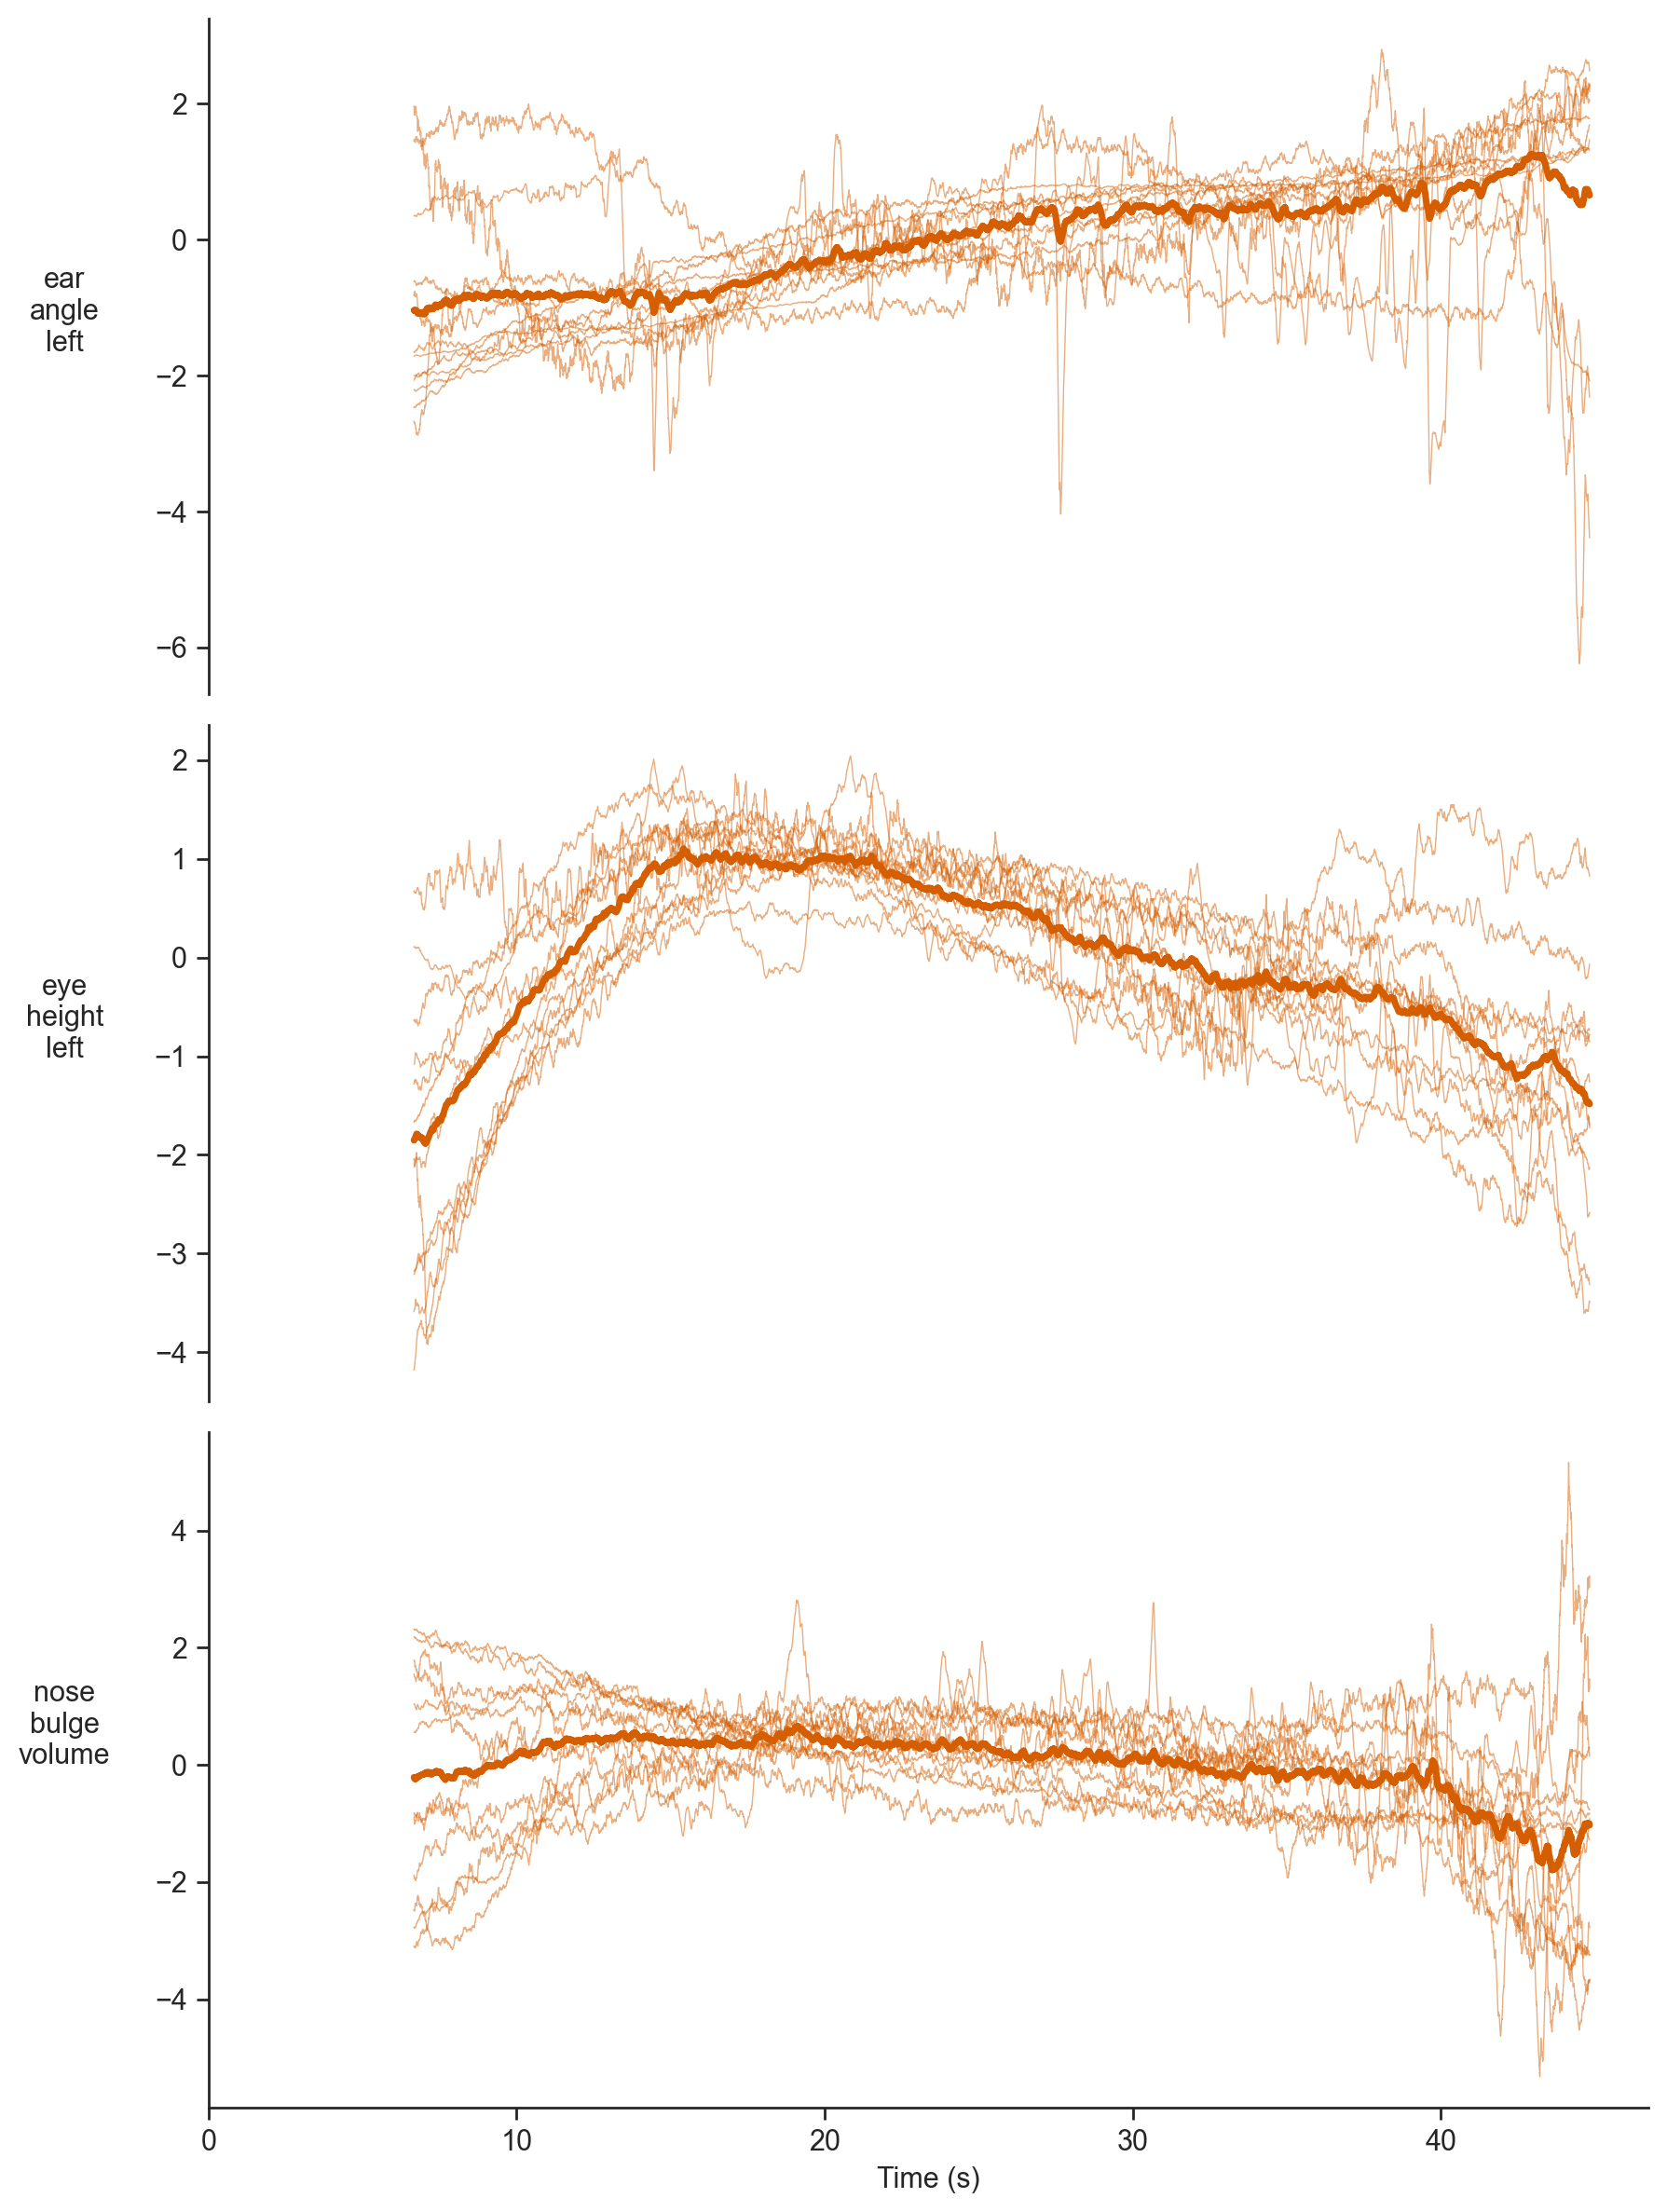

In [25]:
# f_window = 1000 #1000
features = ['ear-angle-left', 'eye-height-left', 'nose-bulge-volume']
fig, axs = plt.subplots(nrows=len(features),
                        ncols=1,
                        figsize=(3*3, 4*3),
                        dpi=200,
                        constrained_layout=False)
meas_summary = {}
time_summary = {}
for row, l in enumerate(features):
    meas_summary[l] = []
    time_summary[l] = []
    y_labels = []

    for sess in anes_data_keys:
        mouse = sess[1]
        date = sess[0]
        if sess in anes_data_keys:
            anes_start = np.max(list(ANES_START_OFFSETS.values())) - ANES_START_OFFSETS[date, mouse] #in seconds - Take the same start for all of them
            ys = data_v2.query(
                    "mouse == @mouse & "
                    "date == @date & "
                    "condition == 'anes' & "
                    "measurement_name == @l"
                )["timeseries"].values[0]
            anes_end = int(np.floor((45 * 60 - ANES_START_OFFSETS[date, mouse]))) * 100 # Trim at 45 minutes since anesthesia injection
            ys = ys[int(np.floor(anes_start)*100):anes_end]

        time = (np.arange(len(ys))/100 + np.max(list(ANES_START_OFFSETS.values())))/ 60 #Note all will start at 5 min and camera sample rate is 100        
        time = time[FILTER_WINDOW:-FILTER_WINDOW]
        # FILTER AND Z SCORED DATA PER MEASUREMENT
        ys = moving_avg_filter(ys, FILTER_WINDOW)
        ys = z_score(ys)
        meas_summary[l].append(ys)
        time_summary[l].append(time)
        sns.lineplot(x = time, y = ys, 
                    color = CONTROL_CMAP_V2[0], linewidth = 0.5, alpha = 0.5,
                    ax = axs[row])
    sns.lineplot(x = time, y = np.mean(meas_summary[l], axis = 0), 
        color = CONTROL_CMAP_V2[0], linewidth = 2.5, 
        ax = axs[row])
    
    axs[row].sharex(axs[0])
    axs[row].set_ylabel(('\n').join(l.split('-')), rotation = 0)
    axs[row].yaxis.set_label_coords(-0.1,0.5)
    if row != (len(features)-1):
        axs[row].tick_params("x", bottom=False, labelbottom=False)
        sns.despine(ax=axs[row], bottom=True)


axs[row].set_xlabel('Time (s)')
axs[row].set_xticks(np.arange(0, 45, 10))
sns.despine(ax=axs[row])

fig.tight_layout()   

fname = "3c-facial-feat-3subset-allmice-10s-avgfilter"
fig.savefig(os.sep.join([OUTPUT_DIR, f"{fname}.svg"]), bbox_inches="tight")

## Figure 3d

(notebook: 2024-08-30-eeg-emg-long-anes.ipynb)

Simultaneously recorded Cheese3D features (top, showing moving average over a 10 sec window; vertical scale bars: ear: 2◦, eye: 0.1mm, nose: 0.5mm3), EEG spectrogram (middle, 5sec FFT window), and power of EEG frequency bands (bottom, showing subdelta: 0.2 Hz to 1 Hz, delta: 1 Hz to 4 Hz, and theta: 5 Hz to 10 Hz bands; vertical scale bars indicate one standard deviation) for an example session.

/home/houlab/micromamba/envs/mouse-fe-analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/houlab/micromamba/envs/mouse-fe-analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/houlab/micromamba/envs/mouse-fe-analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/houlab/micromamba/envs/mouse-fe-analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._f

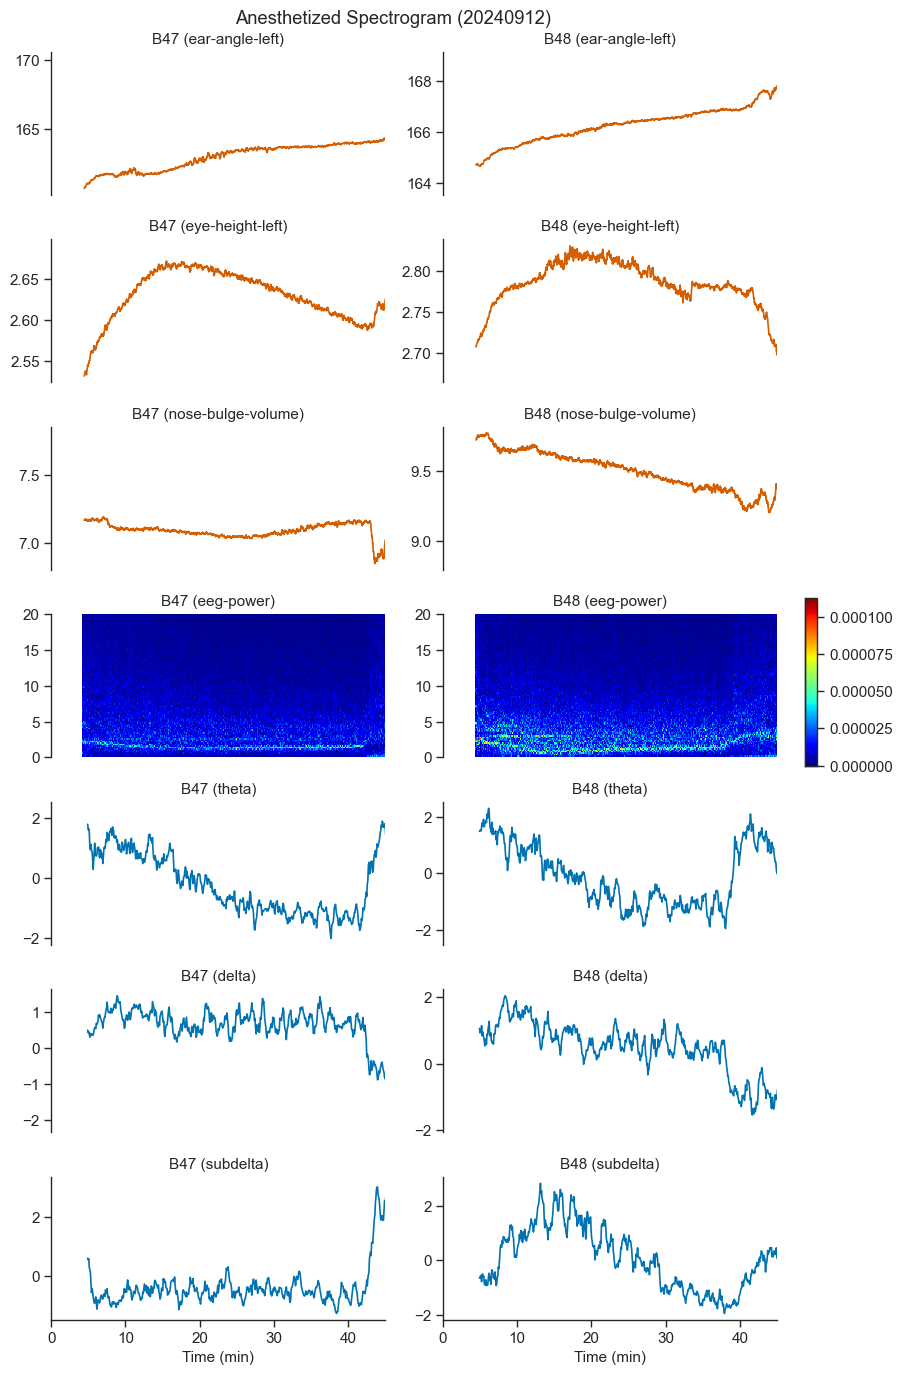

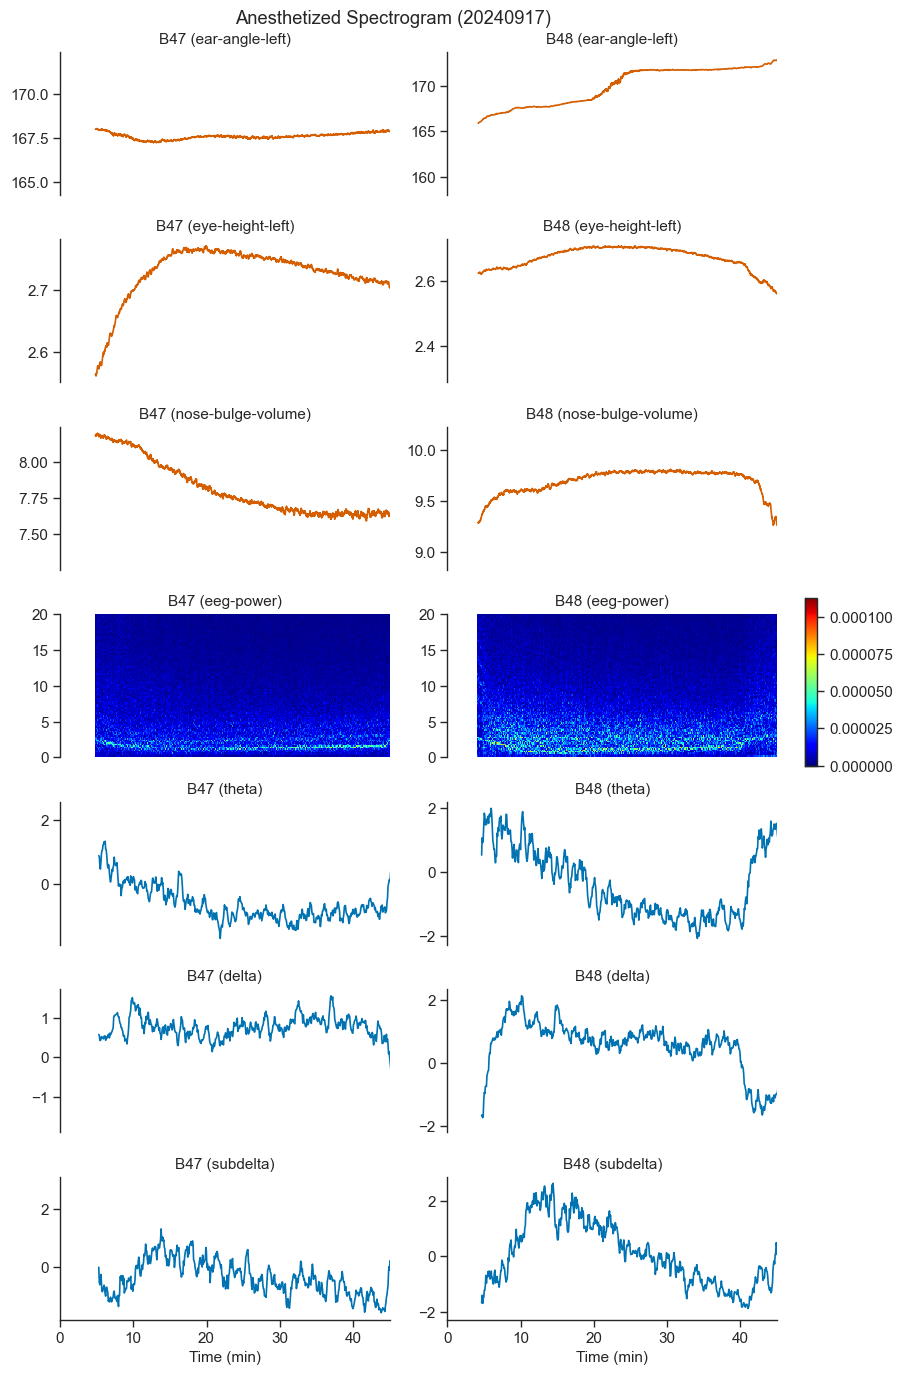

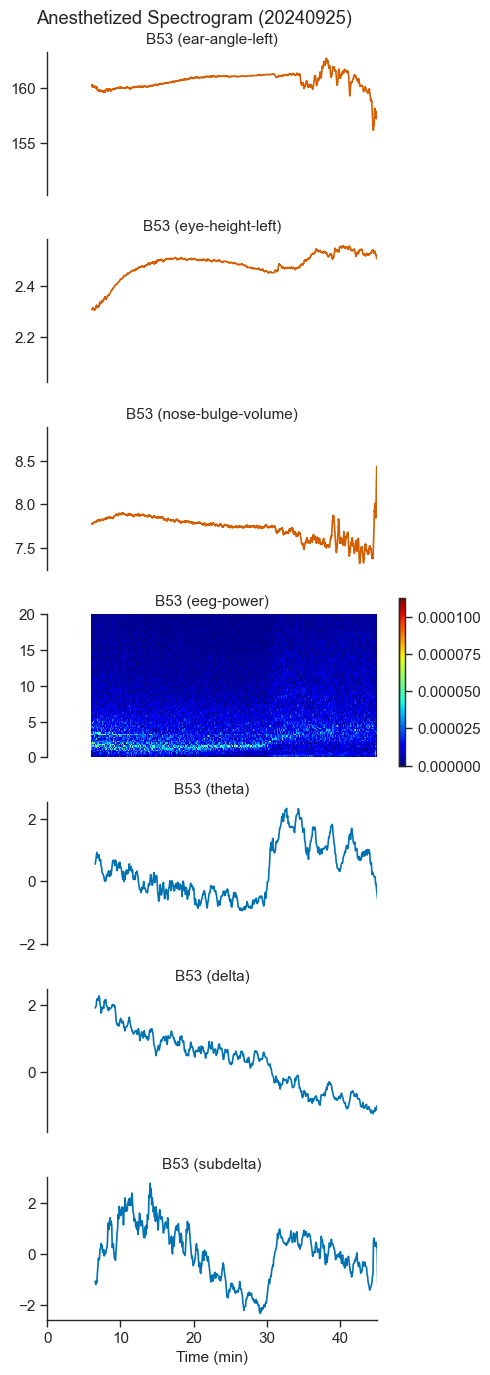

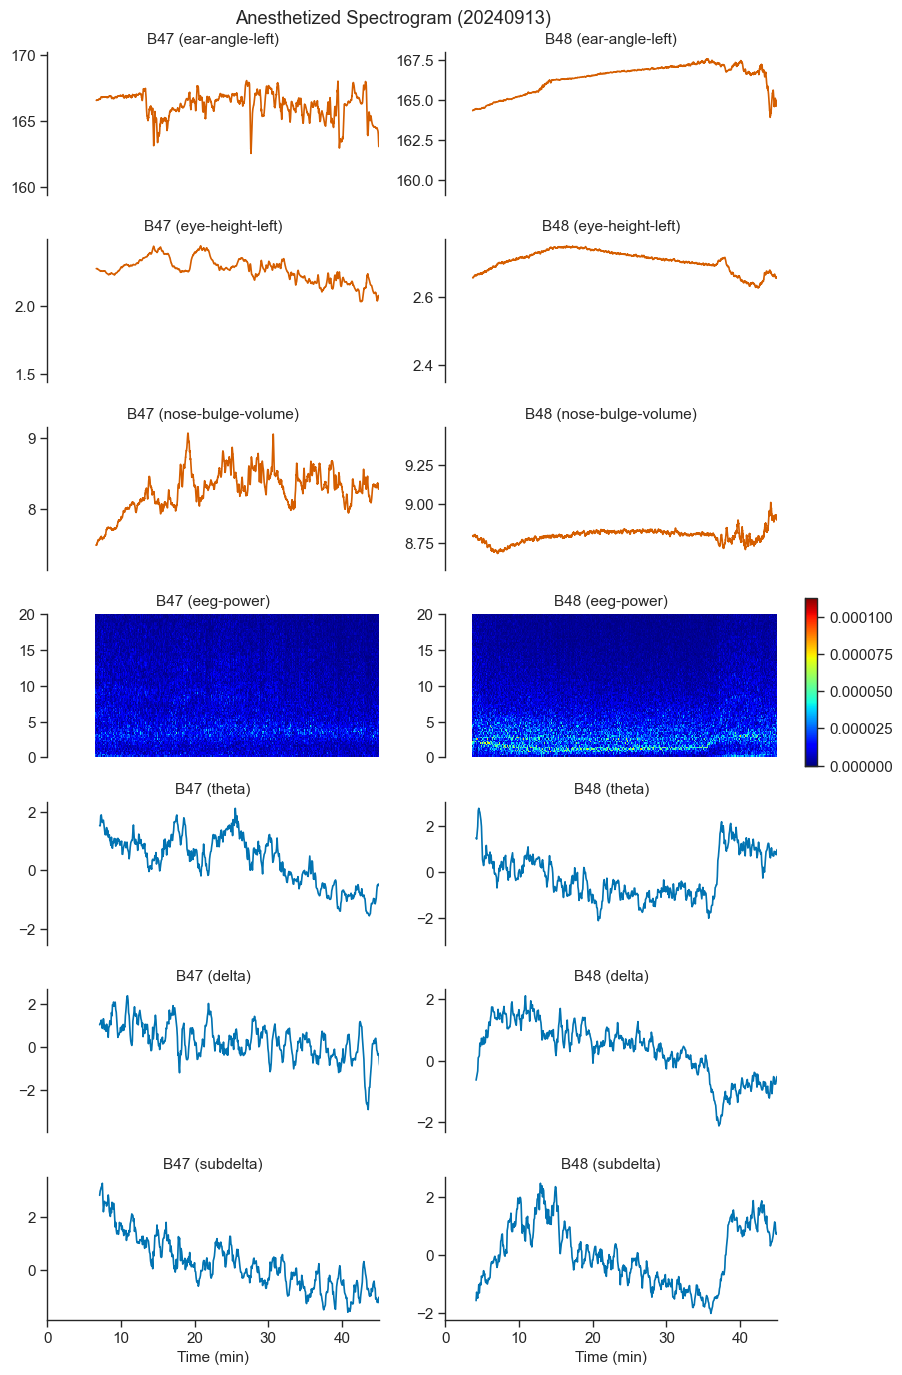

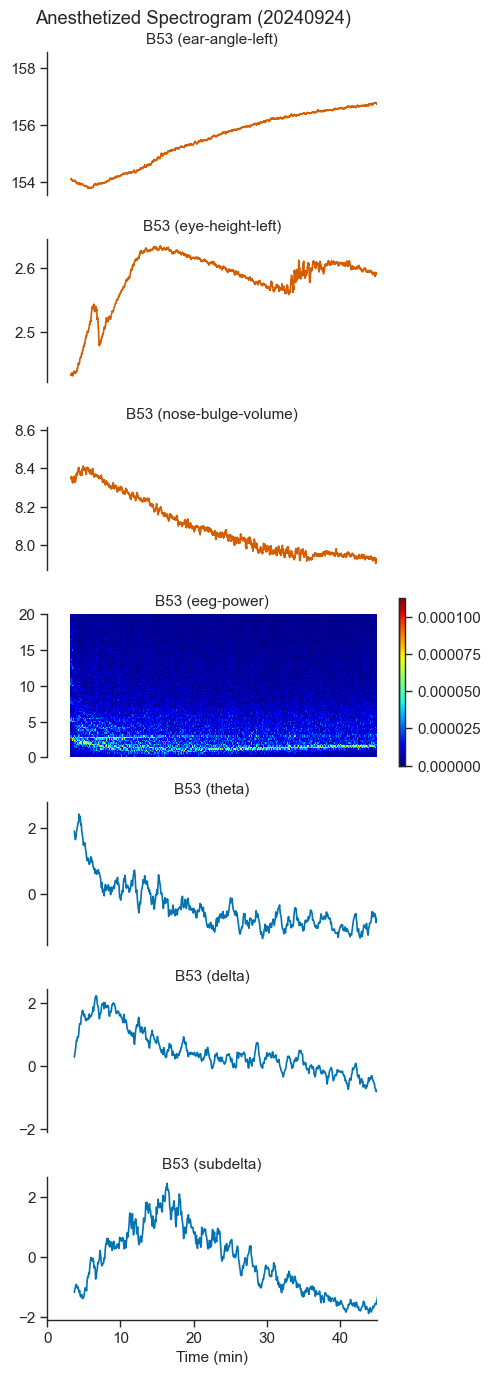

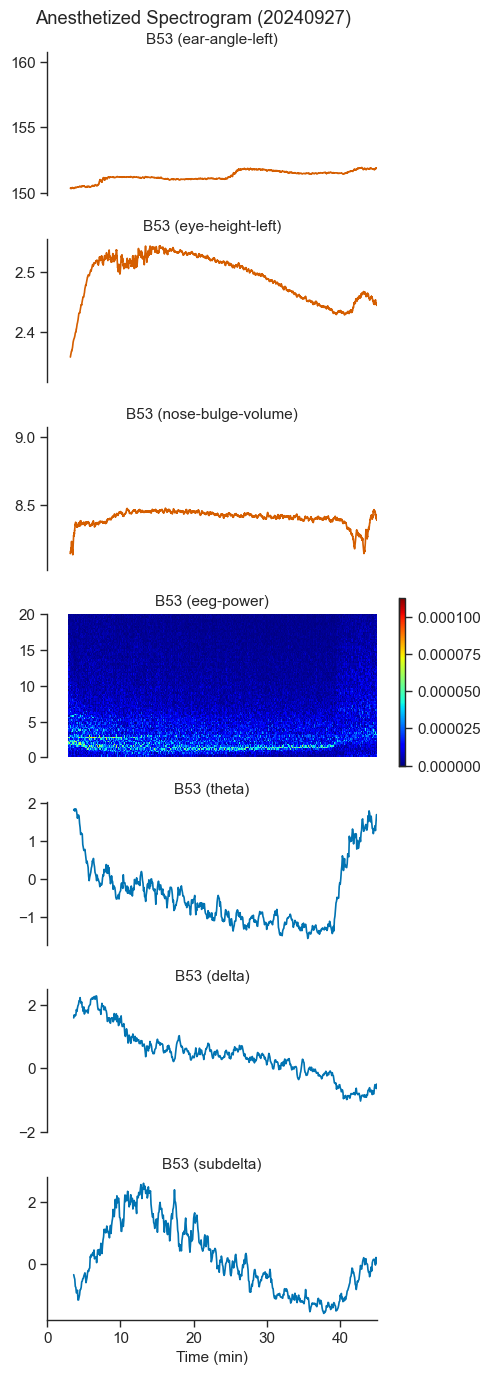

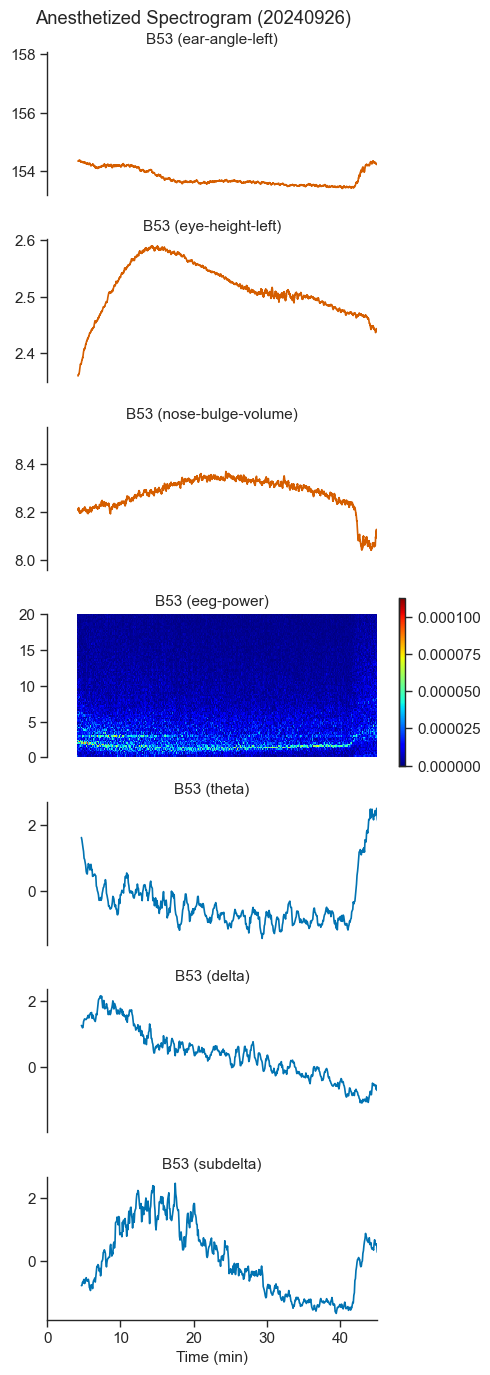

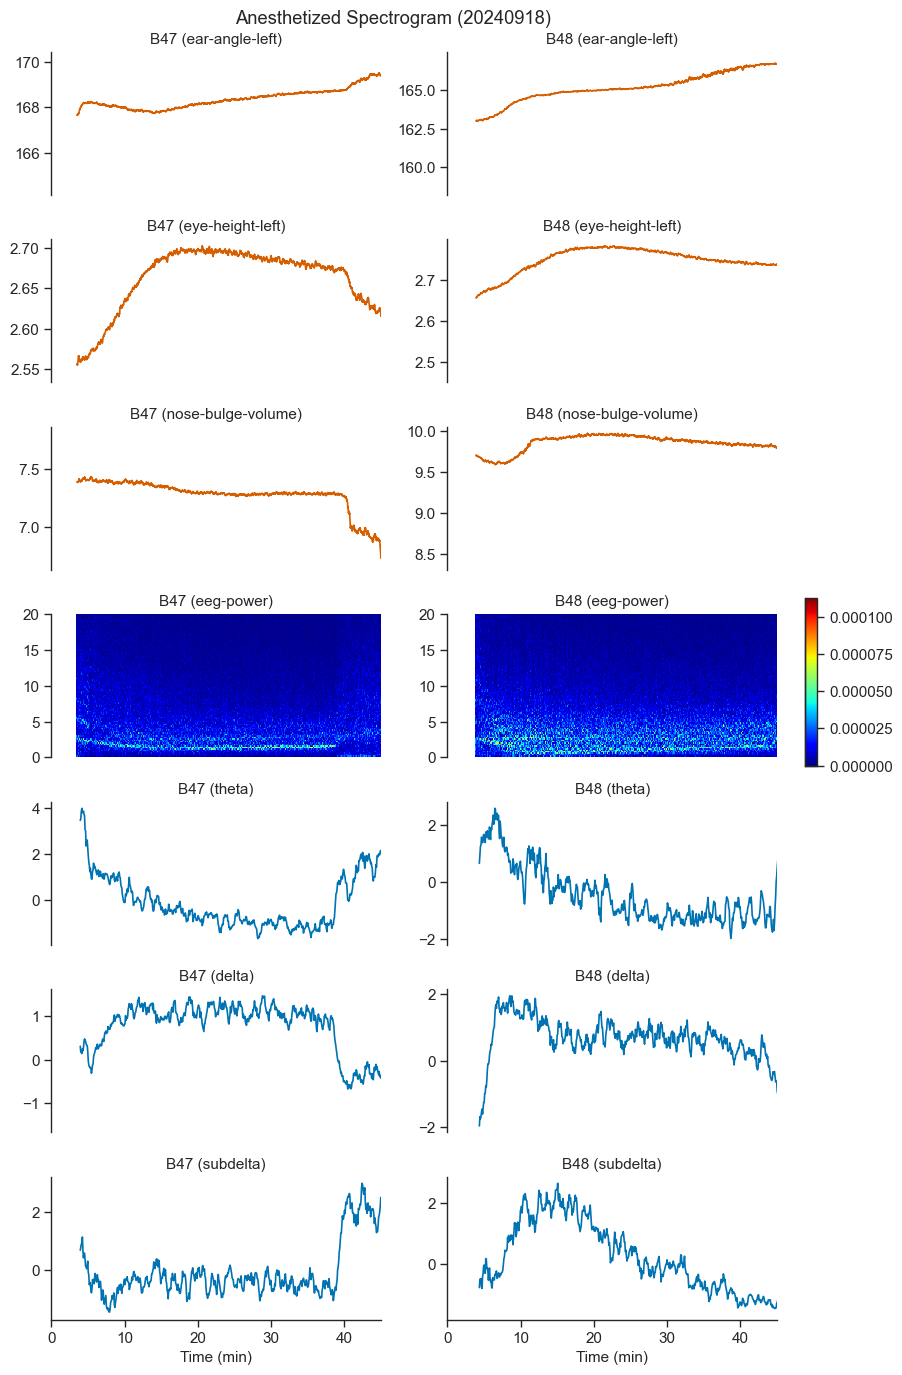

In [26]:
max_power = np.max(data_v2.query("measurement_name == 'eeg-power'").apply(
    lambda x: np.max(x["timeseries"][-1]),
    axis=1
).values)
min_power = np.min(data_v2.query("measurement_name == 'eeg-power'").apply(
    lambda x: np.min(x["timeseries"][-1]),
    axis=1
).values)

def plot_aligned_helper(dates, mice, conditions, style, timeseries, lags, sample_rate, color):
    anes_start = ANES_START_OFFSETS[(dates.values[0], mice.values[0])] #in seconds
    anes_end = -1 #np.floor((45 * 60 - ANES_START_OFFSETS[(dates.values[0], mice.values[0])])) # in seconds - Trim at 45 minutes since anesthesia injection
    awake = (conditions == "awake")
    if style.values[0] == "eeg-power":
        plot_spectrum_helper(dates, mice, conditions, timeseries, lags, color,
                             min_power=min_power, max_power=max_power)
    elif style.values[0] in band_names: 
        _b = timeseries[~awake].values[0][0] #this has already been filtered and zscored (see cell above)
        ts = timeseries[~awake].values[0][1]
        sns.lineplot(x=(ts[:anes_end]+anes_start)/60, 
                     y=_b[:anes_end])
    else:
        ys = timeseries[~awake].values[0]
        ys = ys[:anes_end]
        xs = np.arange(len(ys)) / sample_rate[~awake].values[0]
        xs = xs + anes_start #+ awake_end
        sns.lineplot(x=xs[FILTER_WINDOW:-FILTER_WINDOW] / 60,
                     y=moving_avg_filter(ys, FILTER_WINDOW),
                     color=CONTROL_CMAP[2],
                     label="anes")

measurements = ["ear-angle-left",
                "eye-height-left",
                "nose-bulge-volume",
                "eeg-power",
                "theta",
                "delta",
                "subdelta",
                ]
for d in set(data_and_bands["date"]):
    if d == '20240822':
        continue
    g = sns.FacetGrid(data_and_bands.query("date == @d & "
                                "measurement_name in @measurements"),
                    row="measurement_name", col="mouse",
                    row_order=measurements,
                    sharey=False,
                    sharex=False,
                    # xlim=(0, 70),
                    aspect=2,
                    height=2)
    g.map(plot_aligned_helper,
        "date", "mouse", "condition",
        "measurement_name", "timeseries", "lag_time", "sample_rate")
    cbar_ax = g.figure.add_axes([1.015, 0.44, 0.015, 0.12]) #[1.015, 0.19, 0.015, 0.12]
    plt.colorbar(cax=cbar_ax)
    g.figure.suptitle(f"Anesthetized Spectrogram ({d})")
    g.set_xlabels("Time (min)")
    g.set_ylabels("")
    sns.despine(g.figure)
    for ax in g.axes.flat:
        # if ax.get_xbound()[1] > 65:
        #     ax.set_xticks(np.arange(0, 71, 10))
        # else:
        ax.set_xticks(np.arange(0, 45, 10))
        ax.set_xlim(0, 45)
    for ax in g.axes[-4, :]: # Limit for the EEG spectrogram
        ax.set_ylim(0, 20) 
    for ax in g.axes[:-1, :].flat: # Remove x-ticks except in bottom plot
        ax.set_xticks([])
        sns.despine(ax=ax, bottom=True)
    # for ax in g.axes[-1, :]:
    #     axmin = min(ax.get_xlim()[0], ax.get_ylim()[0])
    #     axmax = max(ax.get_xlim()[1], ax.get_ylim()[1])
    #     ax.plot(np.linspace(axmin, axmax), np.linspace(axmin, axmax), color='black', linestyle="--")
    #     ax.set_aspect('equal', anchor = 'SW', adjustable = 'box')

    g.set_titles(template="{col_name} ({row_name})")
    g.tight_layout()
    fname = f"3d-fe-and-eeg-exemplar-{d}"
    g.figure.savefig(os.sep.join([OUTPUT_DIR, f"{fname}.svg"]), bbox_inches="tight")

## Figure 3e

(notebook: 2024-12-05-long-anes-three-way-predictions-eeg)

Output from a quadratic model fit across mice predicting time since injection using the initial and current Cheese3D (orange) or EEG (blue) feature values relative to the dotted identity line.

In [27]:
EEG_MODEL_NAME = os.sep.join([DATA_CACHE, "lasso-model-mouse-sess-eeg-220runs-interact-stride-init-bias-45minend-Jan30-2ndfix.pkl"])
FF_MODEL_NAME = os.sep.join([DATA_CACHE, "lasso-model-mouse-sess-220runs-interact-stride-init-bias-45minend-Jan30-2ndfix.pkl"])

results_eeg_df_name = 'measurements-data-cache/prediction-eeg-results-220runs-interact-stride-init-bias-45minend-Jan30-2ndfix.pkl'
results_df_name = 'measurements-data-cache/prediction-results-220runs-interact-stride-init-bias-45minend-Jan30-2ndfix.pkl'


Note that the names above correspond to the files used for the manuscript results. If you would like to use a different model, you will need to change the specified names.

Comment the cell below if you would like to run the model code. 

In [28]:
# These are the models and predictions used in the manuscript
# EEG models and results
if os.path.exists(EEG_MODEL_NAME):
    with open(EEG_MODEL_NAME, "rb") as fio:
        models_eeg = pickle.load(fio) # Model results
if os.path.exists(results_eeg_df_name):
    results_eeg_df = pd.read_pickle(results_eeg_df_name) # Prediction results
        
# Facial feature models
if os.path.exists(FF_MODEL_NAME):
    with open(FF_MODEL_NAME, "rb") as fio:
        models_ff = pickle.load(fio)
if os.path.exists(results_eeg_df_name):
    results_df = pd.read_pickle(results_df_name)

/home/houlab/micromamba/envs/mouse-fe-analysis/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Lasso from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/houlab/micromamba/envs/mouse-fe-analysis/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/houlab/micromamba/envs/mouse-fe-analysis/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator

### EEG model

In [29]:
# def run_regression(ts_df, anes_data_keys, features, train_idx, alpha_range, models = None):
def run_regression(ts_df, anes_data_keys, alpha_range):

    # specify feature parameters
    # 20 filter window in samples ~ 40 seconds if nperseg = 2000; 
    # 8 filter window in samples ~ 40 seconds if nperseg = 5000
    # refer to prints about eeg-power sample rate in cell above)
    eeg_window = 8 

    # Polynomial features
    degree = 2 #degree of the polynomial
    lag = 1

    # define empty lists to generate data for model
    measures = []
    target = []

    indeces = []
    counter = 0
    for s_idx, dk in enumerate(anes_data_keys):
        d = dk[0]
        mouse = dk[1]

        # Select input features: eeg-power bands
        eegpower = ts_df.query("mouse == @mouse & date == @d & condition == 'anes' & measurement_name == 'eeg-power'")["timeseries"]
        fs, ts, power = eegpower.values[0]
        _bands = compute_power_bands(fs, power) #type(_bands) = tuple

        # Define actual time
        anes_start = ANES_START_OFFSETS_EEG[(d, mouse)]
        anes_end = int(np.floor((45 * 60 - anes_start) * eeg_power_sr[mouse, d])) # Trim at 45 minutes since anesthesia injection
        _time = ts[:anes_end]
        target.append((_time[eeg_window:-eeg_window] + anes_start) / 60) #lag is only for plotting comparisons against facial features?

        # Filter noise
        bands =[]
        for _b in _bands:
            bands.append(moving_avg_filter(_b[:anes_end], window = eeg_window, stride = 1))
            
        # Z-score and get features
        _measures = np.concatenate((z_score(bands[0][:,na]),        #subdelta
                                    z_score(bands[1][:,na]),        #delta
                                    z_score(bands[2][:,na])), 1)    #theta
        _measures = get_features(_measures, degree, lag, interaction = True, initial_bias = True)
        _measures[:,0] = 1

        # Save indeces in a list of arrays corresponding to each session
        indeces.append(np.arange(_measures.shape[0]) + counter)
        counter += _measures.shape[0]
        measures.append(_measures)

    measures = np.concatenate(measures, axis=0)
    time = np.concatenate(target, axis=0)
    cv = []
    # Annotate indeces to separate into validation and train sets
    for k in range(len(indeces)):
        train_indeces =  np.concatenate([indeces[i] for i in range(len(indeces)) if i != k])  
        test_indeces = indeces[k] #Leave one session out for validation (a.k.a. test within the train set)
        cv.append((train_indeces, test_indeces))         
    
    print(f"Running regression for (subdelta, delta, supdelta)...")
    
    # fit Lasso model and explore alpha space
    mdl = Lasso(fit_intercept=True)
    param_grid = {'alpha': alpha_range} #key must be the same name that is used in Lasso documentation
    model = GridSearchCV(mdl, param_grid, cv = cv, verbose = 0, n_jobs = 8, scoring = "neg_root_mean_squared_error") # Explore hyper-parameter space (only for alpha in this case)
    model.fit(measures[:,1:], time)

    return model


# Explore alpha space below:
alpha_range = np.logspace(-1, 2, 100)

n_runs = 220 #This number should match the len(all_combos) below
n_test = 3 #number of test sessions
test_heldout =[]
all_combos = list(itertools.combinations(range(len(anes_data_keys)), n_test)) #all possible combinations

if os.path.exists(EEG_MODEL_NAME):
    print("Manuscript model has been loaded.")
elif os.path.exists(LASSO_MODEL_EEG):
    print(f"{LASSO_MODEL_EEG} has been loaded.")
    with open(LASSO_MODEL_EEG, "rb") as fio:
        models_eeg = pickle.load(fio) # Model results
else:
    models_eeg = []
    for r in np.arange(n_runs):
        test_heldout_idx = all_combos[r]
        _test_heldout = [d for idx, d in enumerate(anes_data_keys) if idx in test_heldout_idx]
        test_heldout.append(_test_heldout)
        anes_data_keys_train = [d for d in anes_data_keys if d not in _test_heldout] 
        models_eeg.append(run_regression(data_v2, anes_data_keys_train, alpha_range))
    with open(LASSO_MODEL_EEG, "wb") as fio: 
        pickle.dump(models_eeg, fio)



Manuscript model has been loaded.


In [30]:
def get_results_df(data, model, anes_data_keys, test_heldout, n_run = 0):
    eeg_window = 8 
    results = []

    for d in anes_data_keys:
        date = d[0]
        mouse = d[1]
        anes_start = ANES_START_OFFSETS_EEG[(date, mouse)] # in seconds
        anes_end = int(np.floor((45 * 60 - anes_start) * eeg_power_sr[mouse, date])) # Trim at 45 minutes since anesthesia injection   

        # Raw eeg/power data
        eegpower = data.query("mouse == @mouse & date == @date & condition == 'anes' & measurement_name == 'eeg-power'")["timeseries"]
        fs, ts, power = eegpower.values[0]
        _bands = compute_power_bands(fs, power) #type(_bands) = tuple

        # Filter eeg power data
        bands =[]
        for _b in _bands:
            bands.append(moving_avg_filter(_b[:anes_end], window = eeg_window, stride = 1))
        
        # Z-score and get features
        measures = np.concatenate((z_score(bands[0][:,na]),        #subdelta
                                z_score(bands[1][:,na]),        #delta
                                z_score(bands[2][:,na])), 1)    #theta
        test_ts = get_features(measures, degree = 2, lags = 1, interaction = True, initial_bias = True)
        test_ts[:,0] = 1

        # Define actual time
        time = ts[:anes_end]
        time = (time[eeg_window:-eeg_window] + anes_start) / 60 #lag is only for plotting comparisons against facial features?

        # predict time
        times_hat = model.predict(test_ts[:,1:])

        # Compute RMSE
        rmse = np.sqrt(np.mean((times_hat - time) ** 2))

        # Save results
        set_group = "Test" if (date, mouse, 'anes') in test_heldout else "Train"
        results.append([n_run, mouse, date, set_group, "(subdelta, delta, theta)", times_hat, time, rmse])
    
    results_df = pd.DataFrame(results, columns = ["run",
                                            "mouse",
                                            "date",
                                            "set",
                                            "features",
                                            "predicted time",
                                            "actual time",
                                            "RMSE"])
    return results_df

_results_df = []
PREDICTION_RESULTS_EEG_DF = os.sep.join([DATA_CACHE, f'{TODAY}-prediction-eeg-results.pkl'])

if os.path.exists(results_eeg_df_name):
    print("Manuscript prediction results have been loaded.")
elif os.path.exists(PREDICTION_RESULTS_EEG_DF):
    print(f"{PREDICTION_RESULTS_EEG_DF} prediction results have been loaded.")
    results_eeg_df = pd.read_pickle(PREDICTION_RESULTS_EEG_DF) # Prediction results
else:
    for r in np.arange(n_runs):
        _results_df.append(get_results_df(data_v2, models_eeg[r], anes_data_keys, test_heldout[r], r))
    results_eeg_df = pd.concat(_results_df)
    pd.to_pickle(pd.DataFrame(results_eeg_df), PREDICTION_RESULTS_EEG_DF)



Manuscript prediction results have been loaded.


### Facial features model

In [31]:
# def run_regression(ts_df, anes_data_keys, features, train_idx, alpha_range, models = None):
def run_regression(ts_df, anes_data_keys, features, alpha_range):
    
    # specify feature parameters
    f_window = 1000 #6000 #In samples ; For moving_avg_filter the behavior features
    degree = 2 #3 #of the polynomial
    lag = 1

    # define empty lists to generate data for model
    measures = []
    time = []
    
    # data query for input features to the model
    meas_name_query = " | ".join(f"measurement_name == '{feature}'" for feature in features)

    indeces = []
    counter = 0
    for s_idx, dk in enumerate(anes_data_keys):
        d = dk[0]
        mouse = dk[1]

        anes_end = int(45 * 60 - ANES_START_OFFSETS[d, mouse])*100 # Trim at 45 minutes since anesthesia injection   
        _measures = ts_df.query("mouse == @mouse & date == @d & condition == 'anes' & measurement_group != 'ephys' & "
                                "(" + meas_name_query + ")").sort_values("measurement_name")["timeseries"].values

        # Filter noise
        for _ncol, _m in enumerate(_measures):
            _measures[_ncol] = moving_avg_filter(_m[:anes_end], f_window, stride = ds_factor[mouse, d])

        # Z-score
        _measures = z_score(np.stack(_measures, axis=1))
        _measures = get_features(_measures, degree, lag, interaction = True, initial_bias = True)
        _measures[:,0] = 1 #bias should be unaffected by zscoring and thus always 1

        # Save indeces in a list of arrays corresponding to each session
        indeces.append(np.arange(_measures.shape[0]) + counter)
        counter += _measures.shape[0]
        measures.append(_measures)

        # Define actual time
        ys = ts_df.query(
                    "mouse == @mouse & "
                    "condition == 'anes' & "
                    "date == @d & "
                    "measurement_name == @features[0]"
                )["timeseries"].values[0]
        _time = (np.arange(len(ys))/100 + ANES_START_OFFSETS[d, mouse])/ 60 #Note camera sample rate is 100
        _time = _time[:anes_end]
        _time = _time[f_window:-f_window]
        time.append(_time[::ds_factor[mouse, d]])

    measures = np.concatenate(measures, axis=0)
    time = np.concatenate(time, axis=0)
    cv = []
    # Annotate indeces to separate into validation and train sets
    for k in range(len(indeces)):
        train_indeces =  np.concatenate([indeces[i] for i in range(len(indeces)) if i != k])  
        test_indeces = indeces[k] #Leave one out cross-validation (a.k.a. test within the train set)
        cv.append((train_indeces, test_indeces))         
    
    print(f"Running regression for {features}...")
    
    # fit Lasso model and explore alpha space
    mdl = Lasso(fit_intercept=True)
    param_grid = {'alpha': alpha_range} #key must be the same name that is used in Lasso documentation
    model = GridSearchCV(mdl, param_grid, cv = cv, verbose = 0, n_jobs = 6, scoring = "neg_root_mean_squared_error") # Explore hyper-parameter space (only for alpha in this case)
    model.fit(measures[:,1:], time)

    return model

# Select facial features as input to the model
# features = list(set(data_v2.query("measurement_group != 'ephys'")["measurement_name"]))
features = ['eye-height-left', 'ear-angle-left', 'nose-bulge-volume']

# Explore alpha space below:
alpha_range = np.logspace(-1, 2, 100) 
n_runs = 220
n_test = 3 #number of test sessions
test_heldout =[]
all_combos = list(itertools.combinations(range(len(anes_data_keys)), n_test))

if os.path.exists(FF_MODEL_NAME):
    print("Manuscript model has been loaded.")
elif os.path.exists(LASSO_MODEL_FF):
    print(f"{LASSO_MODEL_FF} has been loaded.")  
    with open(LASSO_MODEL_FF, "rb") as fio:
        models_ff = pickle.load(fio) # Model results  
else:
    models_ff = []
    for r in np.arange(n_runs):
        test_heldout_idx = all_combos[r] #np.random.permutation(len(anes_data_keys))[:n_test]
        _test_heldout = [d for idx, d in enumerate(anes_data_keys) if idx in test_heldout_idx]
        print(test_heldout_idx, _test_heldout)
        test_heldout.append(_test_heldout)
        anes_data_keys_train = [d for d in anes_data_keys if d not in _test_heldout] 
        models_ff.append(run_regression(data_v2, anes_data_keys_train, features, alpha_range))
    with open(LASSO_MODEL_FF, "wb") as fio: 
        pickle.dump(models_ff, fio)



Manuscript model has been loaded.


In [32]:
def get_results_df(data, model, anes_data_keys, test_heldout, features, ds_factor, n_run = 0):
  results = []
  # ANES_END = 10 * 60 * 100
  # These should match measurements used as input features
  meas_name_query = " | ".join(f"measurement_name == '{feature}'" for feature in features)
  for d in anes_data_keys:
    date = d[0]
    mouse = d[1]
    anes_end = int(45 * 60 - ANES_START_OFFSETS[date, mouse]) * 100# Trim at 45 minutes since anesthesia injection   
    test_ts = data.query("date == @date & mouse == @mouse & condition == 'anes' & " 
                            "measurement_group != 'ephys' & "
                            "(" + meas_name_query + ")").sort_values("measurement_name")["timeseries"].values

    # Filter noise
    f_window = 1000 #6000 # should be the same as the one used for the regression input features
    for _ncol, _m in enumerate(test_ts):
        test_ts[_ncol] = moving_avg_filter(_m[:anes_end], f_window, stride = ds_factor[mouse, date])
  
    # Z-score
    test_ts = z_score(np.stack(test_ts, axis=1))
    test_ts = get_features(test_ts, degree = 2, lags = 1, interaction = True, initial_bias = True)
    # test_ts = z_score(test_ts)
    test_ts[:,0] = 1

    # Define actual time
    ys = data.query(
                "mouse == @mouse & "
                "date == @date &"
                "condition == 'anes' & "
                "measurement_name == @features[0]"
            )["timeseries"].values[0]
    time = (np.arange(len(ys))/100 + ANES_START_OFFSETS[date, mouse])/ 60 #Note camera sample rate is 100
    time = time[:anes_end]
    time = time[f_window:-f_window]
    time = time[::ds_factor[mouse, date]]
    # predict time
    # m_idx = [0 if mouse == 'B47' else 1 if mouse == 'B48' else 2]
    # model = models[m_idx[0]]
    times_hat = model.predict(test_ts[:,1:])

    # Compute RMSE
    rmse = np.sqrt(np.mean((times_hat - time) ** 2))

    # save results
    set_group = "Test" if (date, mouse, 'anes') in test_heldout else "Train"
    results.append([n_run, mouse, date, set_group, "whole-face", times_hat, time, rmse])

  results_df = pd.DataFrame(results, columns = ["run",
                                                "mouse",
                                                "date",
                                                "set",
                                                "features",
                                                "predicted time",
                                                "actual time",
                                                "RMSE"])
  return results_df


_results_df = []
PREDICTION_RESULTS_FF_DF = f'{TODAY}-prediction-ff-results.pkl'


if os.path.exists(results_df_name):
  print("Manuscript model has been loaded.")
elif os.path.exists(PREDICTION_RESULTS_FF_DF):
  print(f"{PREDICTION_RESULTS_FF_DF} has been loaded.")  
  results_df = pd.read_pickle(PREDICTION_RESULTS_FF_DF) # Prediction results  
else:
  for r in np.arange(n_runs):
    _results_df.append(get_results_df(data_v2, models_ff[r], anes_data_keys, test_heldout[r], features, ds_factor, r))
    results_df = pd.concat(_results_df)
  pd.to_pickle(pd.DataFrame(results_df), PREDICTION_RESULTS_FF_DF)


Manuscript model has been loaded.


### figure

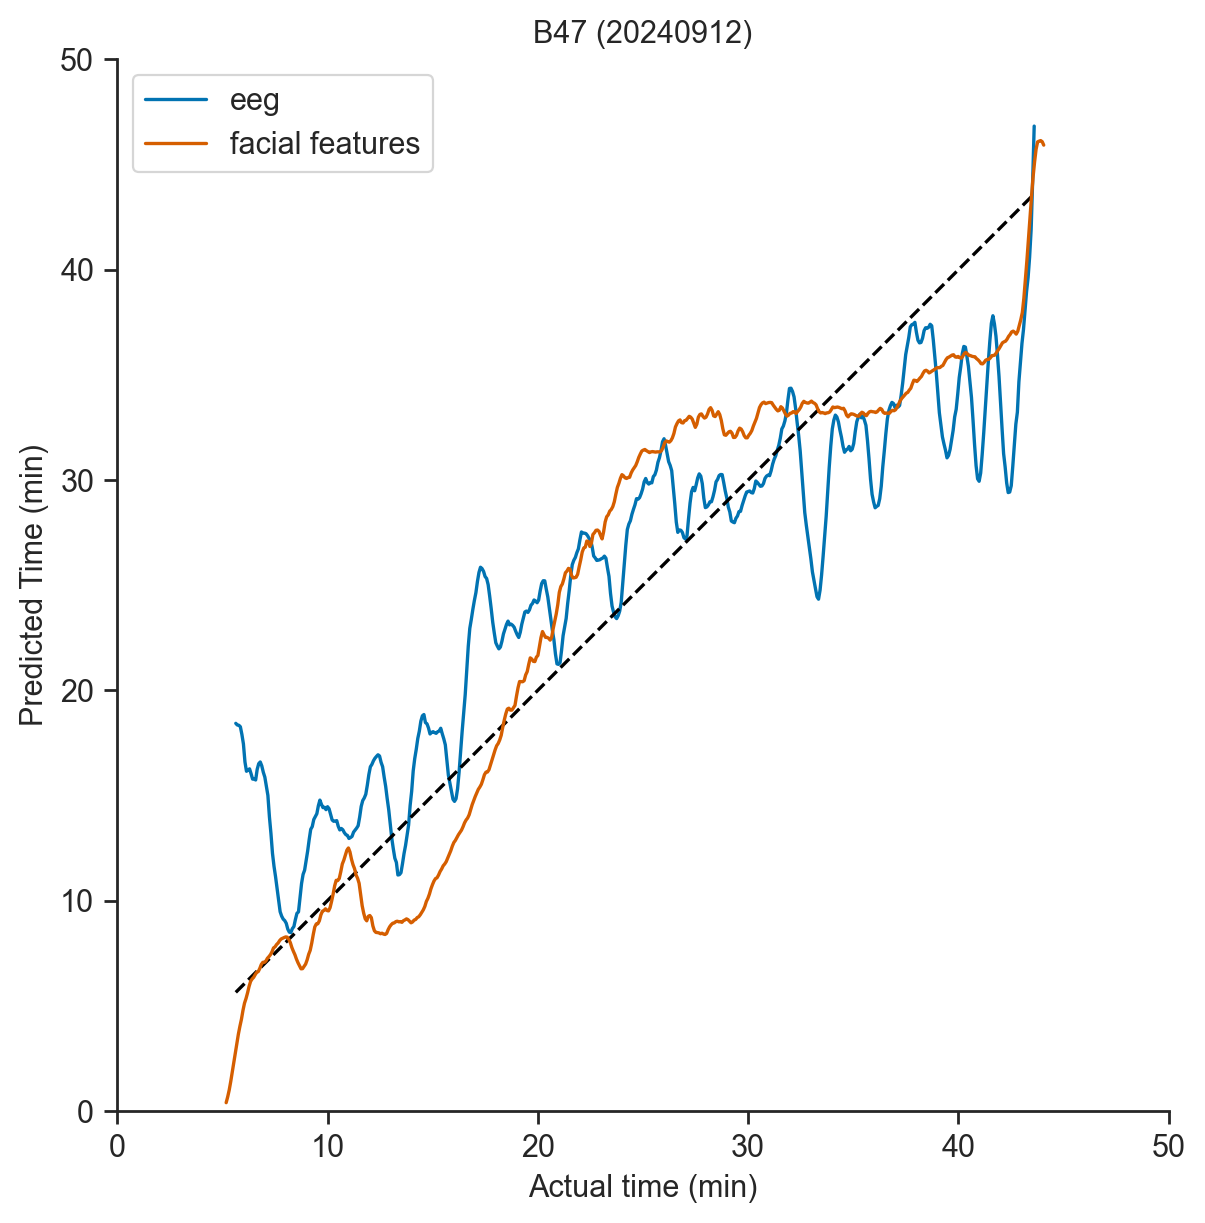

In [33]:
ex_mouse = 'B47'
ex_date = '20240912'
ex_run = [5, 7] #[face, eeg] #215

fig, ax = plt.subplots(nrows= 1,
                        ncols= 1,
                        figsize=(6,6),
                        dpi=200,
                        constrained_layout=True)

plot_predictions(results_eeg_df.query("run == @ex_run[1] & mouse == @ex_mouse & date == @ex_date")["actual time"],
                 results_eeg_df.query("run == @ex_run[1] & mouse == @ex_mouse & date == @ex_date")["predicted time"],
                 FILTER_WINDOW = 10,
                 color = EEG_CONTROL_CMAP[0],
                 label = 'eeg')
plot_predictions(results_df.query("run == @ex_run[0] & mouse == @ex_mouse & date == @ex_date")["actual time"],
                 results_df.query("run == @ex_run[0] & mouse == @ex_mouse & date == @ex_date")["predicted time"],
                 FILTER_WINDOW = 10,
                 color = CONTROL_CMAP[2],
                 label = 'facial features',
                 dash_line = False)

ax.set(title = f"{ex_mouse} ({ex_date})",
       xlabel = "Actual time (min)", ylabel = "Predicted Time (min)",
       xticks=[0, 10, 20, 30, 40, 50], yticks=[0, 10, 20, 30, 40, 50],
       xlim = [0, 50], ylim = [0, 50])
ax.set_aspect("equal", "box")
sns.despine()
fname = f"3e-eeg-vs-ff-regression-ex-{ex_mouse}-{ex_date}"
fig.savefig(os.sep.join([OUTPUT_DIR, f"{fname}.svg"]), bbox_inches="tight")

### statistics

In [ ]:
# Save the mean RMSE results into .csv files
# mean_results_ff_df = test_mean_per_run(results_eeg_df, 220, "(subdelta, delta, theta)")
# mean_results_eeg_df = test_mean_per_run(results_df, 220, "whole-face)")

# mean_results_ff_df.to_csv(f'measurements-data-cache/CSVs/mean_results_ff_df_{TODAY}.csv', index=False)
# mean_results_eeg_df.to_csv(f'measurements-data-cache/CSVs/mean_results_eeg_df_{TODAY}.csv', index=False)

In [43]:
def cv_ttest_corrected(x, y, kfolds, nrepeats, ntrain, ntest):
    diff = x - y
    print(f"Length of the diff ({len(diff)}) should be equal to kfolds * nrepeats ({kfolds * nrepeats})")
    v = np.sum((diff - np.mean(diff))**2) / (len(diff) - 1) # ~= np.std(diff, ddof=1)
    tstat = np.mean(diff) / np.sqrt(v * (1/(kfolds * nrepeats) + ntest/ntrain)) # tstat with correction
    pval = stats.t.sf(np.abs(tstat), nrepeats*kfolds - 1)  # pvalue with correction

    return tstat, pval

In [44]:
eeg_mean_results_df = test_mean_per_run(results_eeg_df, n_runs, "(subdelta, delta, theta)")
face_mean_results_df = test_mean_per_run(results_df, n_runs, "(subdelta, delta, theta)")

stat = cv_ttest_corrected(face_mean_results_df['mean_RMSE'].values, 
                          eeg_mean_results_df['mean_RMSE'].values,
                          n_runs, 1, 9, 3)
print(f" tstat = {stat[0]}\n p-value = {stat[1]}")

Length of the diff (220) should be equal to kfolds * nrepeats (220)
 tstat = 1.495997318844481
 p-value = 0.06804701865112354


## Figure 3f

Root-mean-square error (RMSE) of time prediction where each dot represents the mean test error for one particular model trained on either Cheese3D (orange) or EEG (blue) features.

/tmp/ipykernel_1488041/2760850554.py:6: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.stripplot(test_mean_per_run(results_df, n_runs, "whole-face"),
/tmp/ipykernel_1488041/2760850554.py:12: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.violinplot(test_mean_per_run(results_df, n_runs, "whole-face"),
/tmp/ipykernel_1488041/2760850554.py:22: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  sns.stripplot(test_mean_per_run(results_eeg_df, n_runs, "(subdelta, delta, theta)"),
/tmp/ipykernel_1488041/2760850554.py:28: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  sns.violinplot(test_mean_per_run(results_eeg_df, n_runs, "(subdelta, delta, theta)"),
/tmp/ipykernel_1488041/2760850554.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an u

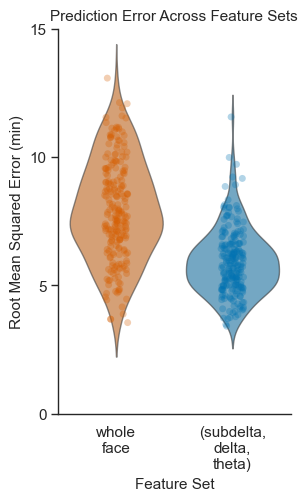

In [34]:
# Plot the results
fig, ax = plt.subplots(figsize=(3, 5))

# Facial features
n_runs = 220
sns.stripplot(test_mean_per_run(results_df, n_runs, "whole-face"), 
              x="features", y="mean_RMSE",
              hue="features", #date #mouse #run
              palette=CONTROL_CMAP_V2,
              legend = False,
              alpha=0.3, ax=ax)
sns.violinplot(test_mean_per_run(results_df, n_runs, "whole-face"), 
              x="features", y="mean_RMSE",
              hue="features", #date #mouse #run
              palette=CONTROL_CMAP_V2,
              legend = False,
              inner = None,
              alpha=0.6, ax=ax)


# EEG power bands
sns.stripplot(test_mean_per_run(results_eeg_df, n_runs, "(subdelta, delta, theta)"), 
              x="features", y="mean_RMSE",
              hue="features",
              palette=EEG_CONTROL_CMAP,
              legend = False,
              alpha=0.3, ax=ax)
sns.violinplot(test_mean_per_run(results_eeg_df, n_runs, "(subdelta, delta, theta)"), 
              x="features", y="mean_RMSE",
              hue="features",
              palette=EEG_CONTROL_CMAP,
              legend = False,
              inner = None,
              alpha=0.6, ax=ax)


ax.set_xlabel("Feature Set")
ax.set_ylabel("Root Mean Squared Error (min)")
ax.set_title("Prediction Error Across Feature Sets")
ax.set_xticks(list(range(len(ax.get_xticklabels()))),
              [format_feature_ticks(f) for f in ax.get_xticklabels()])
ax.tick_params(axis="x", bottom=False)
ax.set_ylim(0, None)
ax.set_yticks(np.arange(0,16,5))
ax.legend(frameon=False, bbox_to_anchor=(1.0, 0.3))
sns.despine(fig)

fname = f"3f-eeg-vs-face-regression-results-summary-violin"
fig.savefig(os.sep.join([OUTPUT_DIR, f"{fname}.svg"]), bbox_inches="tight")

## Figure 3a

(notebook: 2023-long-anes-measurements.ipynb)

Example facial movement raster plot during anesthesia with concurrent EEG recording (each vertical line cor- responds to movement above the 99.9-th percentile jitter threshold as shown in Supplementary Figure 4c for a given 10 ms time window).

### load data and functions from 2023 cohort

In [35]:
# For faster development, limit data to X mice
# Set to a high number to render plots for every mouse
MAX_NUM_MICE = 100

# Plot every row
PLOT_SAMPLE = 100

# Smooth data for visualization
SMOOTH_WINDOW_SIZE = 25

# We didn't measure the amount of time between the end of the awake video and the anesthesia injection
# This adds a constant offset of 5 minutes for every mouse
AWAKE_END_OFFSET = 5*60

# Start of anesthesia video after injection (in seconds)
ANES_START_OFFSETS = {
    'B6': 120,
    'B8': 180,
    'B15': 60,
    'B20': 31,
    'B26': 53,
    'B33': 30,
}

STILL_PERIODS = {
    "B6": (38.50, 44.05),
    "B8": (34.30, 39.55),
    "B15": (27.20, 34.15),
    "B20": (34.55, 41.00),
    "B26": (58.20, 63.28),
    "B33": (44.30, 50.05) #This mouse was commented out in the original notebook (2024-04-05-long-anes-jitter.ipynb)
    # "C3": (0, None)
}

_, MEASUREMENT_CMAP = measurements_cmap()

DATA_CACHE = "measurements-data-cache" 
os.makedirs(DATA_CACHE, exist_ok=True)
COORD_DATA_CACHE = os.sep.join([DATA_CACHE, "long-anes-coords.pkl"])
MEASURE_DATA_CACHE = os.sep.join([DATA_CACHE, "long-anes-meas.pkl"])
JITTER_DATA_CACHE = os.sep.join([DATA_CACHE, "long-anes-jitter-meas.pkl"])

ANIPOSE_BASE = 'anipose-projects/20231013-long-anes-rig2'
COORDINATE_PATHS = {}
key_cols = ('mouse', 'source', 'condition')
for p in Path(ANIPOSE_BASE).glob('*/pose-3d/*.csv'):
    mouse = p.name.split('_')[1]
    source = 'rig2'
    condition = 'awake' if 'awake' in p.name else 'anes'
    COORDINATE_PATHS[(mouse, source, condition)] = p
data_keys = list(COORDINATE_PATHS.keys())
data_keys

[('B26', 'rig2', 'anes'),
 ('B20', 'rig2', 'awake'),
 ('B20', 'rig2', 'anes'),
 ('B8', 'rig2', 'awake'),
 ('B15', 'rig2', 'awake'),
 ('B15', 'rig2', 'anes'),
 ('B8', 'rig2', 'anes'),
 ('B6', 'rig2', 'anes'),
 ('B26', 'rig2', 'awake'),
 ('B6', 'rig2', 'awake')]

In [36]:
def build_measjitter_df(meas_df, periods):
    # select only the subset of rows that match the mouse/source/condition pairs
    queries = [(meas_df["mouse"] == mouse) &
               (meas_df["source"] == "rig2") &
               ((meas_df["condition"] == "anes") | (meas_df["condition"] == "dead"))
               for mouse in periods.keys()]
    sub_df = meas_df[reduce(lambda x, y: x | y, queries)]
    jitter_df = sub_df[[*key_cols,
                        "measurement_group",
                        "measurement_name",
                        "measurement_type",
                        "timeseries"]]
    jitter_df = jitter_df.rename(columns={"measurement_group": "region"})
    jitter_df.loc[(jitter_df["region"] == 'eye') &
                  (jitter_df["measurement_name"].str.contains('left')), "region"] = "eye(left)"
    jitter_df.loc[(jitter_df["region"] == 'eye') &
                  (jitter_df["measurement_name"].str.contains('right')), "region"] = "eye(right)"
    jitter_df.loc[(jitter_df["region"] == 'ear') &
                  (jitter_df["measurement_name"].str.contains('left')), "region"] = "ear(left)"
    jitter_df.loc[(jitter_df["region"] == 'ear') &
                  (jitter_df["measurement_name"].str.contains('right')), "region"] = "ear(right)"
    jitter_df.loc[(jitter_df["region"] == "cheek"), "region"] = "whisker pad"
    jitter_df.loc[(jitter_df["measurement_name"] == "cheek-bulge-volume"), "measurement_name"] = "cheek-bulge-volume"
    jitter_df.loc[(jitter_df["measurement_name"] == "nose-bulge-volume"), "measurement_name"] = "nose-bulge-volume"
    for mouse, period in periods.items():
        start = round(period[0] * 60 * 100) if period[0] is not None else None
        end = round(period[1] * 60 * 100) if period[1] is not None else None
        idx = jitter_df["mouse"] == mouse
        jitter_df.loc[idx, "timeseries"] = jitter_df.loc[idx, "timeseries"].apply(
            lambda x: x[start:end]
        )
    jitter_df["deviations"] = jitter_df.groupby("measurement_name")["timeseries"].transform(
        lambda x: x.apply(lambda xi: xi - xi.mean())
    )
    jitter_df["timeseries_stddev"] = jitter_df.groupby("measurement_name")["deviations"].transform(
        lambda x: x.apply(np.std)
    )
    jitter_df["min_deviation"] = jitter_df.groupby("measurement_name")["deviations"].transform(
        lambda x: x.apply(np.min)
    )
    jitter_df["max_deviation"] = jitter_df.groupby("measurement_name")["deviations"].transform(
        lambda x: x.apply(np.max)
    )
    jitter_df["velocities"] = jitter_df.groupby("measurement_name")["timeseries"].transform(
        lambda x: x.apply(lambda xi: np.abs(np.diff(xi))) * 100
    )
    jitter_df["velocity_mean"] = jitter_df.groupby("measurement_name")["velocities"].transform(
        lambda x: x.apply(np.mean)
    )
    jitter_df["velocity_thresh"] = jitter_df.groupby("measurement_name")["velocities"].transform(
        lambda x: x.apply(lambda xi: np.percentile(xi, 99.9))
    )
    jitter_df["min_velocity"] = jitter_df.groupby("measurement_name")["velocities"].transform(
        lambda x: x.apply(np.min)
    )
    jitter_df["max_velocity"] = jitter_df.groupby("measurement_name")["velocities"].transform(
        lambda x: x.apply(np.max)
    )
    jitter_df["deviations_au"] = jitter_df.groupby("measurement_name")["timeseries"].transform(
        lambda x: x.apply(lambda xi: (xi - xi.mean()) / xi.mean())
    )
    jitter_df["timeseries_stddev_au"] = jitter_df.groupby("measurement_name")["deviations_au"].transform(
        lambda x: x.apply(np.std)
    )
    jitter_df["min_deviation_au"] = jitter_df.groupby("measurement_name")["deviations_au"].transform(
        lambda x: x.apply(np.min)
    )
    jitter_df["max_deviation_au"] = jitter_df.groupby("measurement_name")["deviations_au"].transform(
        lambda x: x.apply(np.max)
    )
    jitter_df["velocities_au"] = jitter_df.groupby("measurement_name")["timeseries"].transform(
        lambda x: x.apply(lambda xi: np.abs(np.diff(xi)) / np.mean(np.abs(np.diff(xi))))
    )
    jitter_df["velocity_mean_au"] = jitter_df.groupby("measurement_name")["velocities_au"].transform(
        lambda x: x.apply(np.mean)
    )
    jitter_df["min_velocity_au"] = jitter_df.groupby("measurement_name")["velocities_au"].transform(
        lambda x: x.apply(np.min)
    )
    jitter_df["max_velocity_au"] = jitter_df.groupby("measurement_name")["velocities_au"].transform(
        lambda x: x.apply(np.max)
    )

    return jitter_df

In [37]:
from scipy.signal import medfilt

if not os.path.exists(COORD_DATA_CACHE):
    print(f"Pre-filtering coordinate data and storing in {COORD_DATA_CACHE}...")
    coord_data = {k: read_3d_data(v.parent.parent.as_posix(),
                                  filter_func=medfilt,
                                  filter_kwargs={'kernel_size': (SMOOTH_WINDOW_SIZE, 1)})
                  for k, v in COORDINATE_PATHS.items()}
    with open(COORD_DATA_CACHE, 'wb') as dict_pkl:
        pickle.dump(coord_data, dict_pkl)
else:
    with open(COORD_DATA_CACHE, 'rb') as dict_pkl:
        coord_data = pickle.load(dict_pkl)

if not os.path.exists(MEASURE_DATA_CACHE):
    print(f"Pre-computing measurements data and storing in {MEASURE_DATA_CACHE}...")
    meas_df = compute_measurements_df(coord_data)
    meas_df.to_pickle(MEASURE_DATA_CACHE)
else:
    meas_df = pd.read_pickle(MEASURE_DATA_CACHE)

if os.path.exists(JITTER_DATA_CACHE):
    jitter_df = pd.read_pickle((JITTER_DATA_CACHE))
else:
    jitter_df = build_measjitter_df(meas_df, STILL_PERIODS)
    # raise RuntimeError("Jitter results not pre-computed. Run jitter analysis notebook.")

In [38]:
awake_end = {
    mouse: len(df)
    for (mouse, _, condition), df in coord_data.items()
    if condition == 'awake'
}
awake_end

{'B20': 28, 'B8': 28, 'B15': 28, 'B26': 28, 'B6': 28}

In [39]:
from collections import defaultdict

mice = list(meas_df["mouse"].unique())
measurement_names = list(meas_df['measurement_name'].unique())
measurement_group_names = list(meas_df['measurement_group'].unique())
measurement_groups = defaultdict(set)
for measurement_name in measurement_names:
    sub_df = meas_df.query("measurement_name == @measurement_name")
    measurement_groups[sub_df['measurement_group'].iloc[0]].add(sub_df['measurement_name'].iloc[0])
measurement_groups

defaultdict(set,
            {'cheek': {'cheek-bulge-volume'},
             'nose': {'nose-bulge-volume'},
             'mouth': {'mouth-area'},
             'ear': {'ear-angle-left',
              'ear-angle-right',
              'ear-area-left',
              'ear-area-right',
              'ear-height-left',
              'ear-height-right',
              'ear-width-left',
              'ear-width-right'},
             'eye': {'eye-area-left',
              'eye-area-right',
              'eye-height-left',
              'eye-height-right',
              'eye-width-left',
              'eye-width-right'}})

In [40]:
from labutils.utils import unzip

def build_timeseries_df(meas_df, data_keys):
    # select only the subset of rows that match the mouse/source/condition pairs
    queries = [(meas_df["mouse"] == mouse) &
               (meas_df["source"] == source) &
               (meas_df["condition"] == condition)
               for mouse, source, condition in data_keys]
    sub_df = meas_df[reduce(lambda x, y: x | y, queries)]
    # compute velocities and pad
    def _process_timeseries(row):
        v = np.abs(np.diff(row["timeseries"]))
        if row["condition"] == "awake":
            p = np.concatenate([row["timeseries"],
                                np.zeros(100 * AWAKE_END_OFFSET)])
            v = np.concatenate([[0], v, np.zeros(100 * AWAKE_END_OFFSET)])
            t = np.arange(-len(p), 0)
        else:
            p = np.concatenate([np.zeros(100 * ANES_START_OFFSETS[row["mouse"]]),
                                row["timeseries"]])
            v = np.concatenate([np.zeros(100 * ANES_START_OFFSETS[row["mouse"]] + 1), v])
            t = np.arange(len(p))

        return p, v, t
    positions, velocities, frames = unzip(sub_df.apply(_process_timeseries, axis=1).values)
    # create new dataframe for velocities spread out over time
    ts_df = sub_df[[*key_cols, "measurement_name"]].copy()
    ts_df = ts_df.assign(position=positions, velocity=velocities, frames=frames)
    ts_df = ts_df.explode(["position", "velocity", "frames"])
    ts_df = ts_df.pivot(index=[*key_cols, "frames"],
                        columns="measurement_name",
                        values=["position", "velocity"])
    ts_df.columns = ["/".join(multicol).strip() for multicol in ts_df.columns.values]
    ts_df.reset_index(inplace=True)
    ts_df = ts_df.assign(**{"time (s)": ts_df["frames"] / 100,
                            "time (min)": ts_df["frames"] / 100 / 60})
    for name in measurement_names:
        ts_df[f"velocity/{name}-std"] = ts_df.groupby("mouse")[f"velocity/{name}"].transform(
            lambda x: x / x.std()
        )
    ts_df.sort_values(["mouse", "frames"], inplace=True)

    return ts_df

ts_df = build_timeseries_df(meas_df, data_keys)
ts_df

,mouse,source,condition,frames,position/cheek-bulge-volume,position/ear-angle-left,position/ear-angle-right,position/ear-area-left,position/ear-area-right,position/ear-height-left,...,velocity/ear-width-right-std,velocity/ear-width-left-std,velocity/ear-height-right-std,velocity/ear-height-left-std,velocity/eye-area-right-std,velocity/eye-area-left-std,velocity/eye-width-right-std,velocity/eye-width-left-std,velocity/eye-height-right-std,velocity/eye-height-left-std
459719,B15,rig2,awake,-60314,41.468829,142.747236,133.916928,78.372833,71.032616,11.492254,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
459720,B15,rig2,awake,-60313,41.403786,142.772817,133.922256,78.439925,71.019604,11.493889,...,0.51254,0.929702,0.724479,0.267774,1.198462,0.893866,0.489492,1.755762,1.379058,0.052902
459721,B15,rig2,awake,-60312,41.348586,142.795097,133.918604,78.505243,71.040266,11.49566,...,0.449352,0.903526,0.152951,0.290173,0.830284,0.245394,0.354379,1.011237,0.924719,0.156723
459722,B15,rig2,awake,-60311,41.309236,142.814831,133.916759,78.544046,71.057798,11.49707,...,0.508354,0.591443,0.05318,0.230927,0.817349,0.340543,0.353808,0.6019,0.841534,0.001622
459723,B15,rig2,awake,-60310,41.288503,142.831748,133.909521,78.571558,71.083224,11.498879,...,0.454798,0.372695,0.325173,0.296372,0.30795,0.409896,0.229707,0.870044,0.207232,0.161265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923497,B8,rig2,anes,414565,45.876012,167.796258,168.618843,74.995804,79.384955,12.215365,...,1.918611,2.104149,0.988142,0.352078,0.845704,0.886031,0.72536,0.49299,0.686413,0.292672
2923498,B8,rig2,anes,414566,45.829837,167.767614,168.596125,75.008324,79.376116,12.20957,...,1.759536,1.467621,0.283081,1.995652,0.433143,1.03582,0.706191,0.649544,0.120839,0.421903
2923499,B8,rig2,anes,414567,45.794624,167.735023,168.576594,74.999246,79.356303,12.20478,...,2.123502,0.781568,0.018447,1.649676,0.426622,1.228952,0.531552,0.920058,0.366404,0.533792
2923500,B8,rig2,anes,414568,45.767987,167.699105,168.56243,74.95163,79.329723,12.198222,...,2.103271,0.221297,0.581182,2.258305,0.154103,2.520297,0.537264,3.931943,0.420699,0.663679


### figure

B15 ear-angle-left threshold = 0.03363517298181981
B15 ear-angle-right threshold = 0.040011944067326506
B15 eye-area-left threshold = 0.012859419006357975
B15 eye-area-right threshold = 0.01001362937326335
B15 mouth-area threshold = 0.010036126847192718
B15 cheek-bulge-volume threshold = 0.09355608219984309
B15 nose-bulge-volume threshold = 0.024194644767541004
B20 ear-angle-left threshold = 0.029006055144875566
B20 ear-angle-right threshold = 0.022585962201699124
B20 eye-area-left threshold = 0.012896094119992596
B20 eye-area-right threshold = 0.00791716153300582
B20 mouth-area threshold = 0.004666618306762274
B20 cheek-bulge-volume threshold = 0.06207223209626119
B20 nose-bulge-volume threshold = 0.01789766116390993
B26 ear-angle-left threshold = 0.03198963583395927
B26 ear-angle-right threshold = 0.025329843067814488
B26 eye-area-left threshold = 0.007328029356684964
B26 eye-area-right threshold = 0.0052831198865205715
B26 mouth-area threshold = 0.00853567125644936
B26 cheek-bulge-v

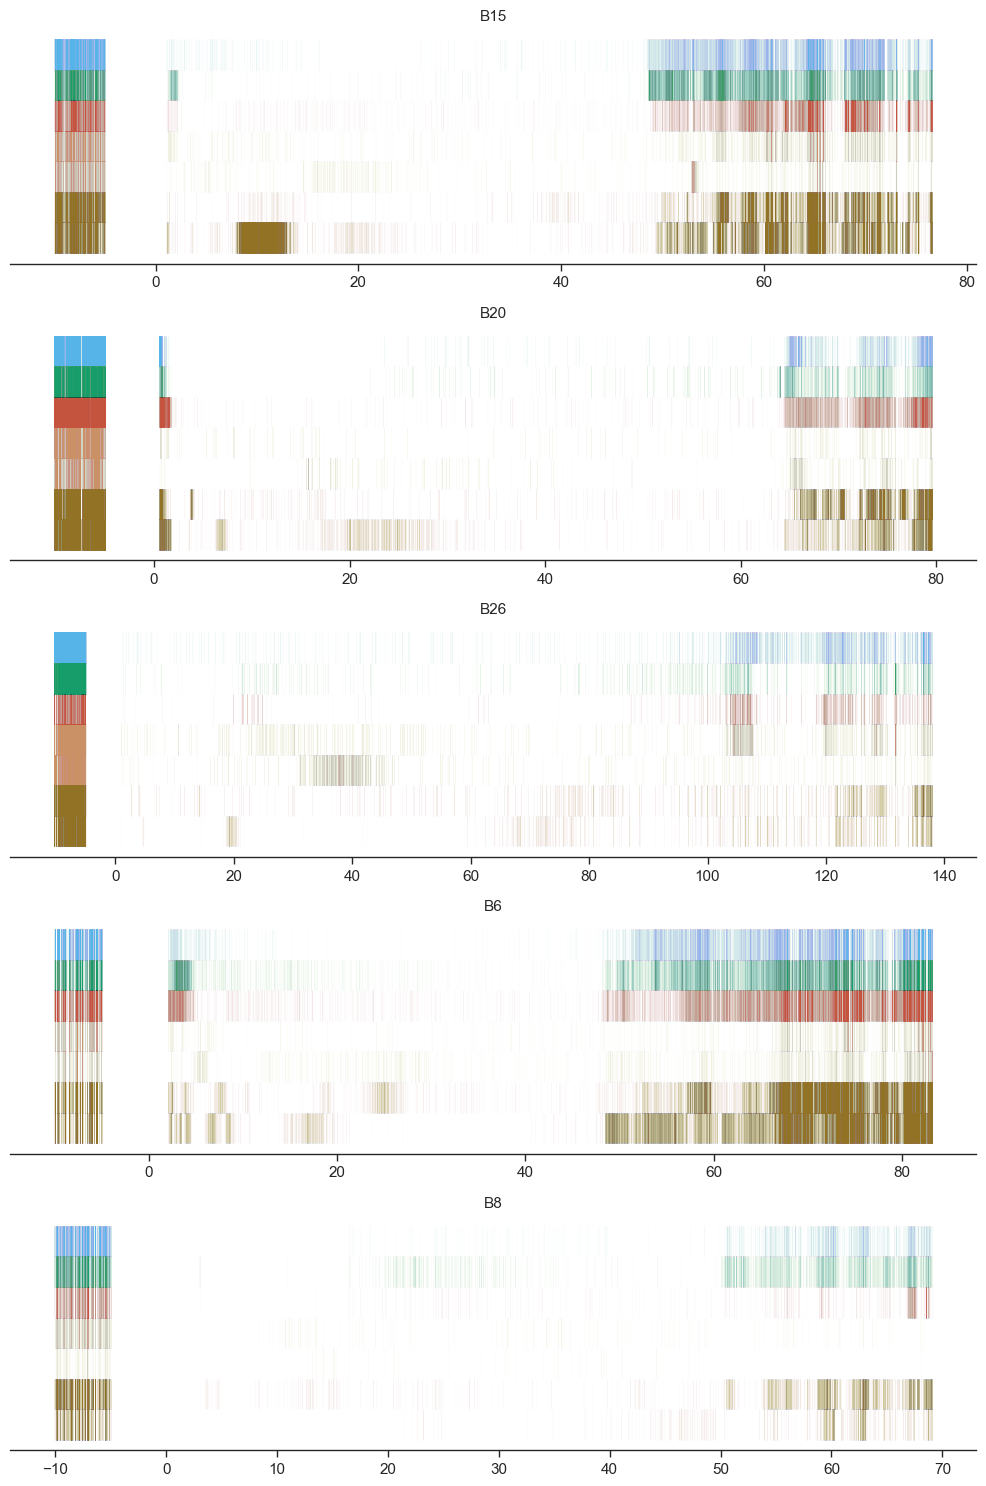

In [41]:
PLOT_SAMPLE = 1

time_col = "time (min)"
plot_meas = ["velocity/ear-angle-left",
             "velocity/ear-angle-right",
             "velocity/eye-area-left",
             "velocity/eye-area-right",
             "velocity/mouth-area",
             "velocity/cheek-bulge-volume",
             "velocity/nose-bulge-volume"]
cols = [time_col] + plot_meas
column_order = [time_col] + plot_meas
fig, axs = plt.subplots(nrows=len(mice),
                        # sharex=True,
                        figsize=(10, 3 * len(mice)))

for mouse, ax in zip(filter(lambda x: x != "B33", mice), axs):
    # get plotting subset
    sub_df = ts_df.query('mouse == @mouse')[cols].copy()
    sub_df = sub_df[column_order]
    sub_df.set_index(time_col, inplace=True)
    sub_df = sub_df.iloc[::PLOT_SAMPLE, :]

    # ax = axs[ax_num]
    for i, column in enumerate(plot_meas):
        meas_name = column.split("/")[-1]
        baseline = jitter_df.query("mouse == @mouse & "
                                "measurement_name == @meas_name")["velocities"]
        baseline = baseline.values[0] / 100 # convert mm / s -> mm / frame
        thresh = np.percentile(baseline, 99.9)
        # thresh = np.std(baseline)
        print(mouse, meas_name, "threshold =", thresh)
        ticks = sub_df.index[sub_df[column] > thresh]
        # Plot vertical lines for threshold crossing events
        if len(ticks) > 0:
            ax.vlines(ticks, i, i - 1,
                      colors=MEASUREMENT_CMAP[meas_name],
                      alpha=0.01,
                      linewidths=0.5)

    ax.set_title(mouse)
    ax.tick_params(axis="y", left=False)
    ax.set_yticklabels([])
    ax.get_xaxis().set_ticks_position('bottom')
sns.despine(fig, left=True, top=True, right=True)
fig.tight_layout()

fname = f"3a-long-anes-tick-rasters-allmice"
fig.savefig(os.sep.join([OUTPUT_DIR, f"{fname}.png"]), bbox_inches="tight")
# save_figure(OUTPUT_DIR, "long-anes-panel-e-exemplar_ticks", fig, formats=["png"])

## Figure 3b

(notebook: 2023-long-anes-measurements.ipynb)

Zoom in of movement raster plot from (a) to show the early moments of movement recovery following anesthesia.

B15 ear-angle-left threshold = 0.03363517298181981
B15 ear-angle-right threshold = 0.040011944067326506
B15 eye-area-left threshold = 0.012859419006357975
B15 eye-area-right threshold = 0.01001362937326335
B15 mouth-area threshold = 0.010036126847192718
B15 cheek-bulge-volume threshold = 0.09355608219984309
B15 nose-bulge-volume threshold = 0.024194644767541004
B20 ear-angle-left threshold = 0.029006055144875566
B20 ear-angle-right threshold = 0.022585962201699124
B20 eye-area-left threshold = 0.012896094119992596
B20 eye-area-right threshold = 0.00791716153300582
B20 mouth-area threshold = 0.004666618306762274
B20 cheek-bulge-volume threshold = 0.06207223209626119
B20 nose-bulge-volume threshold = 0.01789766116390993
B26 ear-angle-left threshold = 0.03198963583395927
B26 ear-angle-right threshold = 0.025329843067814488
B26 eye-area-left threshold = 0.007328029356684964
B26 eye-area-right threshold = 0.0052831198865205715
B26 mouth-area threshold = 0.00853567125644936
B26 cheek-bulge-v

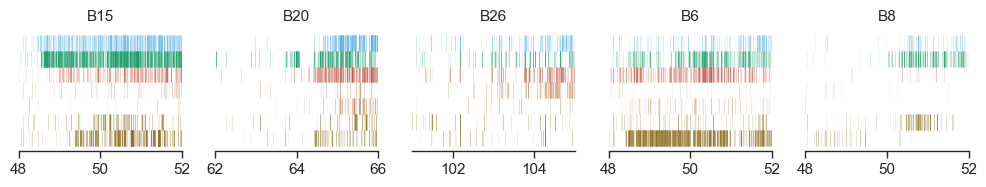

In [42]:
fig, axs = plt.subplots(1, len(mice), figsize=(2 * len(mice), 2))

wakeup_window = {
    "B15": (48, 52),
    "B20": (62, 66),
    "B26": (101, 105),
    "B6": (48, 52),
    "B8": (48, 52)
}

for mouse, ax in zip(filter(lambda x: x != "B33", mice), axs):
    sub_df = ts_df.query('mouse == @mouse')[cols].copy()
    sub_df = sub_df[column_order]
    sub_df.set_index(time_col, inplace=True)
    sub_df = sub_df.iloc[::PLOT_SAMPLE, :]

    for i, column in enumerate(plot_meas):
        meas_name = column.split("/")[-1]
        baseline = jitter_df.query("mouse == @mouse & "
                                   "measurement_name == @meas_name")["velocities"]
        baseline = baseline.values[0] / 100 # convert mm / s -> mm / frame
        thresh = np.percentile(baseline, 99.9)
        # thresh = np.std(baseline)
        print(mouse, meas_name, "threshold =", thresh)
        ticks = sub_df.index[sub_df[column] > thresh]
        # Plot vertical lines for threshold crossing events
        if len(ticks) > 0:
            ax.vlines(ticks, i, i - 1,
                      colors=MEASUREMENT_CMAP[meas_name],
                      alpha=0.1,
                      linewidths=0.5)

    ax.set_xlim(*wakeup_window[mouse])
    ax.set_title(mouse)
    ax.tick_params(axis="y", left=False)
    ax.set_yticklabels([])
    ax.get_xaxis().set_ticks_position('bottom')
sns.despine(fig, left=True, top=True, right=True)
fig.tight_layout()

fname = f"3b-long-anes-tick-rasters-allmice-zoom"
fig.savefig(os.sep.join([OUTPUT_DIR, f"{fname}.png"]), bbox_inches="tight")
# save_figure(OUTPUT_DIR, "long-anes-panel-f-exemplar_ticks_zoom", fig, formats=["png"])